# H&M Retail Sales Analysis
---

# Import Packages and Load data

There are three tables within this [Kaggle dataset](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data?select=transactions_train.csv):
- `articles`: Detailed metadata for each article_id (product) available for purchase.
- `customers`: metadata for each customer_id in dataset.
- `transactions`: The purchases each customer for each date, as well as additional information. Duplicate rows correspond to multiple purchases of the same item.

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from statsmodels.regression import linear_model
# import statsmodels.api as sm
from scipy import stats
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import warnings
import joblib
from tqdm import tqdm

#a bunch of imports!
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


# Text Processing
import string
import nltk
import re 
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer


# Lemmatization

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Imbalance learning
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Model Evaluation
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

warnings.filterwarnings('ignore')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wellswang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/wellswang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/wellswang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/wellswang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
plt.rcParams['figure.figsize']=(5,3.5)

In [17]:
articles = pd.read_csv('data/articles.csv')

In [18]:
customers = pd.read_csv('data/customers.csv')

In [19]:
transactions = pd.read_csv('data/transactions_train.csv')

---

# Data Cleaning

As a data analyst, I want to conduct data preprocessing on the H&M Sales data in order to better identify quality issues, and feature engineering opportunities, and to have further observations about the data: 
- Looking individually into the 3 tables for preprocessing.
- Drop columns that might fall out of scope for this project.
- Merge them into a final dataframe for the further EDA.

---

## Articles

In [6]:
articles.head(3)

article_id  product_code      prod_name  product_type_no product_type_name  \
0   108775015        108775      Strap top              253          Vest top   
1   108775044        108775      Strap top              253          Vest top   
2   108775051        108775  Strap top (1)              253          Vest top   

   product_group_name  graphical_appearance_no graphical_appearance_name  \
0  Garment Upper body                  1010016                     Solid   
1  Garment Upper body                  1010016                     Solid   
2  Garment Upper body                  1010017                    Stripe   

   colour_group_code colour_group_name  ...  department_name index_code  \
0                  9             Black  ...     Jersey Basic          A   
1                 10             White  ...     Jersey Basic          A   
2                 11         Off White  ...     Jersey Basic          A   

   index_name index_group_no  index_group_name section_no  \
0  Ladieswear              1        Ladieswear         16   
1  Ladieswear              1        Ladieswear         16   
2  Ladieswear              1        Ladieswear         16   

             section_name garment_group_no  garment_group_name  \
0  Womens Everyday Basics             1002        Jersey Basic   
1  Womens Everyday Basics             1002        Jersey Basic   
2  Womens Everyday Basics             1002        Jersey Basic   

                               detail_desc  
0  Jersey top with narrow shoulder straps.  
1  Jersey top with narrow shoulder straps.  
2  Jersey top with narrow shoulder straps.  

[3 rows x 25 columns]

### Shapes, missing values, and duplicates

`articles` is the product table for this dataset. First we look at the shape, NANs, and duplicated of this table.

In [7]:
articles.shape

(105542, 25)

There are more than 100k available products (rows), and 25 columns.

In [8]:
articles.isna().sum()

article_id                        0
product_code                      0
prod_name                         0
product_type_no                   0
product_type_name                 0
product_group_name                0
graphical_appearance_no           0
graphical_appearance_name         0
colour_group_code                 0
colour_group_name                 0
perceived_colour_value_id         0
perceived_colour_value_name       0
perceived_colour_master_id        0
perceived_colour_master_name      0
department_no                     0
department_name                   0
index_code                        0
index_name                        0
index_group_no                    0
index_group_name                  0
section_no                        0
section_name                      0
garment_group_no                  0
garment_group_name                0
detail_desc                     416
dtype: int64

Here we can see that the only column with missing values is detail_desc, which is around 0.4% of the total rows. 

In [9]:
articles[articles['detail_desc'].isna()==1]

article_id  product_code                   prod_name  product_type_no  \
1467    351332007        351332        Marshall Lace up Top              252   
2644    420049002        420049                  OL TAGE PQ               87   
2645    420049003        420049                  OL TAGE PQ               87   
2742    426199002        426199  Ellen Shortie Daisy Low 3p              286   
2743    426199010        426199  Ellen Shortie Daisy Low 3p              286   
...           ...           ...                         ...              ...   
67838   752458001        752458           Poissy boho dress              265   
72720   768842001        768842                 Andrews set              270   
72721   768842004        768842                 Andrews set              270   
93144   856985001        856985                   Pogo rope               67   
95624   867200001        867200              Necklace Simon               77   

      product_type_name  product_group_name  graphical_appearance_no  \
1467            Sweater  Garment Upper body                  1010018   
2644              Boots               Shoes                  1010016   
2645              Boots               Shoes                  1010016   
2742   Underwear bottom           Underwear                  1010016   
2743   Underwear bottom           Underwear                  1010017   
...                 ...                 ...                      ...   
67838             Dress   Garment Full body                  1010007   
72720       Garment Set   Garment Full body                  1010017   
72721       Garment Set   Garment Full body                  1010004   
93144              Belt         Accessories                  1010016   
95624          Necklace         Accessories                  1010011   

      graphical_appearance_name  colour_group_code colour_group_name  ...  \
1467                  Treatment                  7              Grey  ...   
2644                      Solid                 13             Beige  ...   
2645                      Solid                 23       Dark Yellow  ...   
2742                      Solid                  9             Black  ...   
2743                     Stripe                  8         Dark Grey  ...   
...                         ...                ...               ...  ...   
67838                Embroidery                 10             White  ...   
72720                    Stripe                 10             White  ...   
72721                     Check                 73         Dark Blue  ...   
93144                     Solid                 12       Light Beige  ...   
95624                  Metallic                  3            Silver  ...   

         department_name index_code          index_name index_group_no  \
1467     Jersey Fancy DS          D             Divided              2   
2644     Premium Quality          C  Ladies Accessories              1   
2645     Premium Quality          C  Ladies Accessories              1   
2742     Casual Lingerie          B    Lingeries/Tights              1   
2743     Casual Lingerie          B    Lingeries/Tights              1   
...                  ...        ...                 ...            ...   
67838              Dress          A          Ladieswear              1   
72720     Baby Boy Woven          G    Baby Sizes 50-98              4   
72721     Baby Boy Woven          G    Baby Sizes 50-98              4   
93144              Belts          C  Ladies Accessories              1   
95624  Small Accessories          F            Menswear              3   

       index_group_name section_no            section_name garment_group_no  \
1467            Divided         58        Divided Selected             1005   
2644         Ladieswear         64            Womens Shoes             1020   
2645         Ladieswear         64            Womens Shoes             1020   
2742         Ladieswear         61         Womens L

In [10]:
articles.duplicated().sum()

0

No duplicated rows in `articles`.

---

### Code and name pairs

It seems like columns are stored with duplicated information with *code/no* and *name* pairs. Here we can take a look at if codes are assign to more than 1 name. After cleaning, we would drop the codes for EDA (Might bring back codes for machine learning).

In [11]:
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

Only `product_group_name` is not paired with code.  
Here, we deal with the following code and name pairs individually:
| Code / No.                | Name                        |
|---------------------------|-----------------------------|
| product_code              | prod_name                   |
| product_type_no           | product_type_name           |
| graphical_appearance_no   | graphical_appearance_name   |
| colour_group_code         | colour_group_name           |
| perceived_colour_value_id | perceived_colour_value_name |
| department_no             | department_name             |
| index_code                | index_name                  |
| index_group_no            | index_group_name            |
| section_no                | section_name                |
| garment_group_no          | garment_group_name          |

In [20]:
# Find out code name pairs that are not in 1-to-1 relationships
cnpairs = articles.drop(['article_id','product_group_name', 'detail_desc'], axis=1).copy()
code=[]
name=[]
diff=[]
for i in range(0, len(cnpairs.columns),2):
    code.append(cnpairs.columns[i])
    name.append(cnpairs.columns[i+1])
    diff.append(cnpairs.iloc[:,i].nunique()-cnpairs.iloc[:,i+1].nunique())
cnpairs_diff = pd.DataFrame({
    'code':code,
    'name':name,
    'diff':diff
})
cnpairs_diff

code                          name  diff
0                 product_code                     prod_name  1349
1              product_type_no             product_type_name     1
2      graphical_appearance_no     graphical_appearance_name     0
3            colour_group_code             colour_group_name     0
4    perceived_colour_value_id   perceived_colour_value_name     0
5   perceived_colour_master_id  perceived_colour_master_name     0
6                department_no               department_name    49
7                   index_code                    index_name     0
8               index_group_no              index_group_name     0
9                   section_no                  section_name     1
10            garment_group_no            garment_group_name     0

It seems like we need to look further into the following pairs:

In [13]:
cnpairs_diff[cnpairs_diff['diff']>0]

code               name  diff
0     product_code          prod_name  1349
1  product_type_no  product_type_name     1
6    department_no    department_name    49
9       section_no       section_name     1

---

#### product_code and prod_name

- It seems like 2176 product_code have more than 1 prod_name.

In [21]:
# Finding product_code with more than one unique prod_name
code_name_pairs_product = articles.groupby('product_code')['prod_name'].nunique().reset_index()
code_name_pairs_product[code_name_pairs_product['prod_name']>1].head()

product_code  prod_name
0         108775          2
18        146706          2
29        156610          2
31        160442          2
39        179123          2

In [15]:
articles[articles['product_code']==188183].head(3)

article_id  product_code                  prod_name  product_type_no  \
160   188183001        188183  Spanx alot shape Swimsuit               57   
161   188183008        188183    SPANX ALOT swimsuit (1)               57   
162   188183009        188183    SPANX ALOT swimsuit (1)               57   

    product_type_name product_group_name  graphical_appearance_no  \
160          Swimsuit           Swimwear                  1010016   
161          Swimsuit           Swimwear                  1010016   
162          Swimsuit           Swimwear                  1010017   

    graphical_appearance_name  colour_group_code colour_group_name  ...  \
160                     Solid                  9             Black  ...   
161                     Solid                  8         Dark Grey  ...   
162                    Stripe                 10             White  ...   

     department_name index_code        index_name index_group_no  \
160         Swimwear          B  Lingeries/Tights              1   
161         Swimwear          B  Lingeries/Tights              1   
162         Swimwear          B  Lingeries/Tights              1   

     index_group_name section_no                section_name garment_group_no  \
160        Ladieswear         60  Womens Swimwear, beachwear             1018   
161        Ladieswear         60  Womens Swimwear, beachwear             1018   
162        Ladieswear         60  Womens Swimwear, beachwear             1018   

     garment_group_name                                        detail_desc  
160            Swimwear  Fully lined shaping swimsuit that has a sculpt...  
161            Swimwear  Fully lined shaping swimsuit that has a sculpt...  
162            Swimwear  Fully lined shaping swimsuit that has a sculpt...  

[3 rows x 25 columns]

We can see that the product_code with different prod_name are just having minor differences in strings. We can replace them with the most frequent name for each product code:

In [22]:
# Assigning only the most frequent name to each code
code_name_pairs_product_mode = articles.groupby('product_code')['prod_name'].agg(lambda x: pd.Series.mode(x)[0]).to_frame().reset_index()
code_name_pairs_product_mode.head()

product_code                  prod_name
0        108775                  Strap top
1        110065          OP T-shirt (Idro)
2        111565        20 den 1p Stockings
3        111586  Shape Up 30 den 1p Tights
4        111593   Support 40 den 1p Tights

Sanity check... for every product_code, we only want to have one corresponding prod_name

In [23]:
(code_name_pairs_product_mode.groupby('product_code')['prod_name'].nunique()>1).sum()

0

Finally, we can replace the prod_name to make sure each product_code is paired with only one prod_name.

In [24]:
# Replace prod_name (resulting 1-to-1 relationship for product_code and prod_name)
product_ref = articles[['product_code']].copy().merge(code_name_pairs_product_mode, how='left', on='product_code')
articles['prod_name'] = product_ref['prod_name']

Sanity check again:

In [19]:
(articles.groupby('product_code')['prod_name'].nunique()>1).sum()

0

**Note**: if we view it inversely:  
`(articles.groupby('prod_name')['product_code'].nunique()>1).sum()`  
We can see that there are multiple product_code sharing the same prod_name. Let's just ignore that for now.

---

#### product_type_no and product_type_name

As we know the unique count of product_type_no and product_type_name is different. Let's see if a product_type_no is having 2 or more product_type_name.

In [20]:
# Finding product_type_no with more than one unique prod_type_name
(articles.groupby('product_type_no')['product_type_name'].nunique()>1).sum()

0

No product_type_no is having duplicated names, let's check if it's another way around:

In [21]:
# Finding product_type_name with more than one unique prod_type_no
(articles.groupby('product_type_name')['product_type_no'].nunique()>1).sum()

1

We have 1 product_type_name that shares different product_type_no:

In [22]:
j = articles.groupby('product_type_name')['product_type_no'].nunique().reset_index()
j[j['product_type_no']>1]

product_type_name  product_type_no
113          Umbrella                2

"Umbrella" product type has 2 corresponding product_type_no. It seems like not a big deal. I think we can safely drop the product_type_no column for the EDA as of this point.

---

#### department_no and department_name

In [23]:
# Finding department_no with more than one unique department_name
(articles.groupby('department_no')['department_name'].nunique()>1).sum()

0

In [24]:
j = articles.groupby('department_name')['department_no'].nunique().reset_index()
j[j['department_no']>1].sort_values(by='department_no', ascending=False).head()

department_name  department_no
124        Knitwear             11
208         Trouser              7
81           Jersey              5
173          Shorts              5
165           Shirt              4

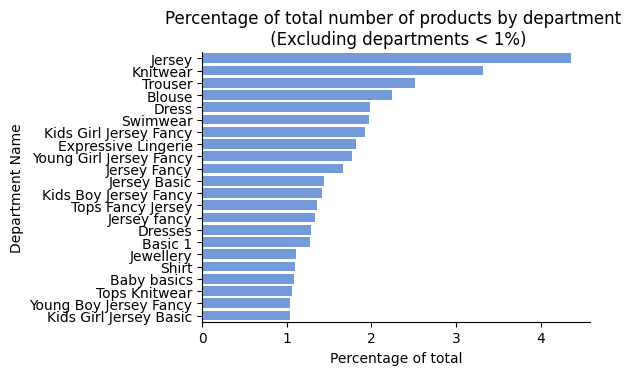

In [25]:
j = articles['department_name'].value_counts(normalize=True).reset_index()
j['perc'] = j['proportion']*100
j[j['proportion']>=0.01]

# Plotting dist by department_name
sns.barplot(j[j['proportion']>=0.01], x='perc', y='department_name',
           color='cornflowerblue')
sns.despine()
plt.title('Percentage of total number of products by department \n (Excluding departments < 1%)')
plt.xlabel('Percentage of total')
plt.ylabel('Department Name')

plt.show();

We do see some department_no have the same name. However, dropping no. and keep the department name as it is seems to still be applicable. In fact, we might want to drop both columns corresponding to department as the information stored is overlapping with other columns (i.e. product_group). We can discuss this in the EDA.

#### section_no and section_name

In [26]:
# Finding product_type_no with more than one unique prod_type_name
(articles.groupby('section_no')['section_name'].nunique()>1).sum()

0

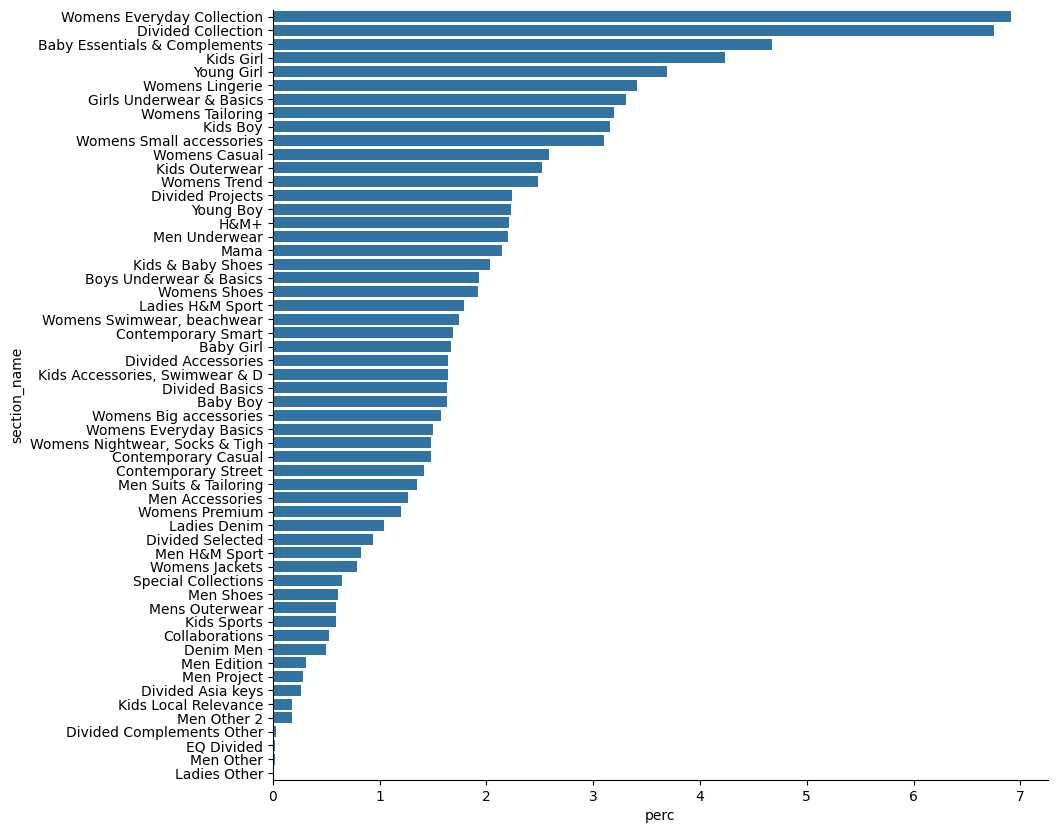

In [27]:
j = articles['section_name'].value_counts(normalize=True).reset_index()
j['perc'] = j['proportion']*100
plt.figure(figsize=(10,10))
sns.barplot(j, x='perc', y='section_name')
sns.despine()

We can drop section_no safely here as well, seems like section would be a column worth keeping by looking at the rather evenly distributed distribution.

---

### Dropping code columns

- After looking into the columns and some cleaning, we can now safely drop the "code/no." columns to remove duplicated informations among columns. 
- We will keep the product_code here since we will be using it later, and there are duplicated prod_name for different product_code


In [26]:
# Getting the code columns from the cnpairs_diff dataframe defined earlier
cols_to_drop = cnpairs_diff.iloc[1:,0].to_list()
print(cols_to_drop)
print(f'columns before dropping: {articles.shape[1]}')

# Dropping columns
articles.drop(cols_to_drop, axis=1, inplace=True)
print(f'columns after dropping: {articles.shape[1]}')

['product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id', 'perceived_colour_master_id', 'department_no', 'index_code', 'index_group_no', 'section_no', 'garment_group_no']
columns before dropping: 25
columns after dropping: 15


After dropping, we have 15 columns left in the articles table!

---

## Customers

### Shape, missing values, and duplicates

Again, for the customer table, we look at the shape, NANs, and duplicated first.

In [29]:
customers.shape

(1371980, 7)

Over 1.3M of customers, and 7 columns. Much less information here than in the articles table. Let's see if there are useful ones, we can drop those that are not useful.

In [30]:
customers.head()

customer_id   FN  Active  \
0  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...  NaN     NaN   
1  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...  NaN     NaN   
2  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...  NaN     NaN   
3  00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...  NaN     NaN   
4  00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...  1.0     1.0   

  club_member_status fashion_news_frequency   age  \
0             ACTIVE                   NONE  49.0   
1             ACTIVE                   NONE  25.0   
2             ACTIVE                   NONE  24.0   
3             ACTIVE                   NONE  54.0   
4             ACTIVE              Regularly  52.0   

                                         postal_code  
0  52043ee2162cf5aa7ee79974281641c6f11a68d276429a...  
1  2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...  
2  64f17e6a330a85798e4998f62d0930d14db8db1c054af6...  
3  5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...  
4  25fa5ddee9aac01b35208d01736e57942317d756b32ddd...

In [31]:
customers.isna().sum()

customer_id                    0
FN                        895050
Active                    907576
club_member_status          6062
fashion_news_frequency     16011
age                        15861
postal_code                    0
dtype: int64

We can already see some NaNs here in FN and Active. [Here](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/discussion/305952#1684481), we found a comment left by the competition host explaining these two variables:
- **FN**: if a customer get Fashion News newsletter
- **Active**: if the customer is active for communication

In [32]:
customers.duplicated().sum()

0

No duplicated rows.

---

### Imputing missing values

In [33]:
customers['FN'].value_counts()

FN
1.0    476930
Name: count, dtype: int64

In [34]:
customers['Active'].value_counts()

Active
1.0    464404
Name: count, dtype: int64

In [35]:
customers['club_member_status'].value_counts()

club_member_status
ACTIVE        1272491
PRE-CREATE      92960
LEFT CLUB         467
Name: count, dtype: int64

- `FN` and `Active` are either 1 or NaN, we would replace the NaN with 0 here.
- `club_member_status` are either ACTIVE, PRE_CREATE, or LEFT CLUB, we can assign NONE to the NaN obs.

In [27]:
# Impute NaNs for FN, Active, and club_member_status 
customers['FN'] = -customers['FN'].isna()
customers['Active'] = -customers['Active'].isna()
customers['club_member_status'] = customers['club_member_status'].fillna('NONE')

In [28]:
customers['fashion_news_frequency'].value_counts()

fashion_news_frequency
NONE         877711
Regularly    477416
Monthly         842
Name: count, dtype: int64

For the `fashion_news_frequency`, we would assign NaNs to the already exist **NONE** category.

In [29]:
# Impute fashion_news_frequency
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].fillna('NONE')

---

Next, age is a tricky one. Let's look at the distribution first.

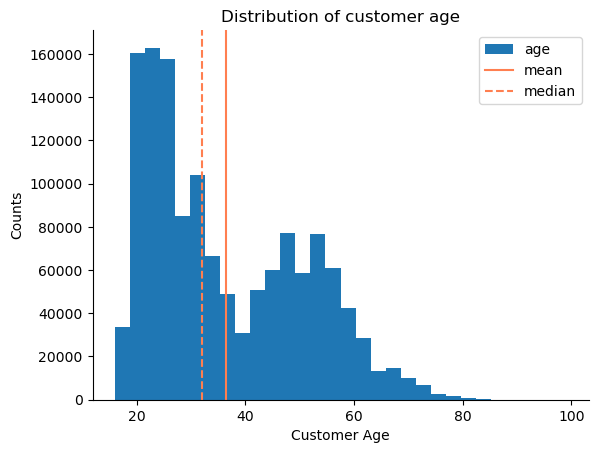

In [30]:
customers['age'].plot(kind='hist', bins=30)
plt.axvline(customers['age'].mean(), 0, 2000, c='coral', label='mean')
plt.axvline(customers['age'].median(), 0, 2000, c='coral', label='median', linestyle='--')
sns.despine()
plt.title('Distribution of customer age')
plt.xlabel('Customer Age')
plt.ylabel('Counts')
plt.legend()
plt.show();

In [31]:
print(customers['age'].isna().sum())
print(customers['age'].isna().mean()*100)

15861
1.1560664149623172


We have 15861 missing values for age, which is around 1.15% of the total observations. Imputing them with median age of all customers might not skew the distribution too much.

In [32]:
# fill NaN for customer age with median
customers['age'] = customers['age'].fillna(customers['age'].median())

Sanity check the distribution:

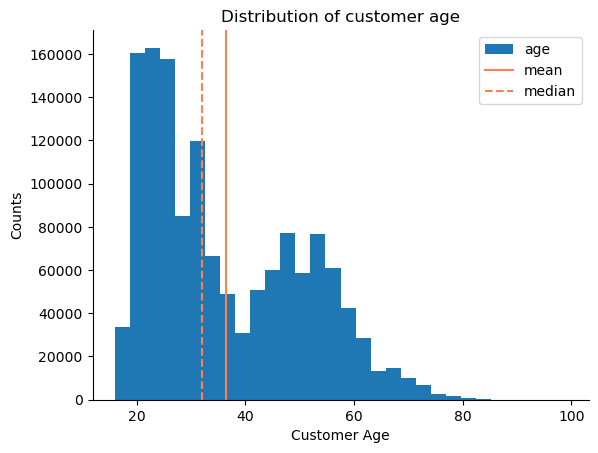

In [33]:
customers['age'].plot(kind='hist', bins=30)
plt.axvline(customers['age'].mean(), 0, 2000, c='coral', label='mean')
plt.axvline(customers['age'].median(), 0, 2000, c='coral', label='median', linestyle='--')
sns.despine()
plt.title('Distribution of customer age')
plt.xlabel('Customer Age')
plt.ylabel('Counts')
plt.legend()
plt.show();

Finally, sanity check if we have dealt with all missing values:

In [43]:
customers.isna().sum()

customer_id               0
FN                        0
Active                    0
club_member_status        0
fashion_news_frequency    0
age                       0
postal_code               0
dtype: int64

**Note**: postal_code seems to be tokenized. We assume it is from all around the globe, hence might be messy. However, it is our only information about customer location. I think we can keep it for now and try to see if any valuable information could be derived from it.

In [44]:
customers['postal_code'].nunique()

352899

In [45]:
(customers['postal_code'].value_counts()<=10).sum()

341957

We have 352k unique postal code. However, 341k of them have less than 10 observations. Hmm... I might want to drop it before modeling, unless we can retrieve more information from the tokenized string.

---

## Transactions

In [46]:
transactions.head()

t_dat                                        customer_id  article_id  \
0  2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   663713001   
1  2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   541518023   
2  2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   505221004   
3  2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   685687003   
4  2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   685687004   

      price  sales_channel_id  
0  0.050831                 2  
1  0.030492                 2  
2  0.015237                 2  
3  0.016932                 2  
4  0.016932                 2

It looks like we only have 5 columns in transactions:
- With **customer_id** we can merge the `customers` table.
- With **article_id** we can merge the `articles` table.
- **price** column here would be our only source if we want to approximate revenue for certain product category or time period (since we don't have price information in the `articles` table).  We don't have informations about the product *costs* as well.
- For **sales_channel_id**, we need to look further into what actual channel the id corresponds to.

### Shape, missing values, and duplicates

In [47]:
transactions.shape

(31788324, 5)

We have 31.7M transactions in our data...Let's check if any of the rows have missing values.

In [48]:
transactions.isna().sum()

t_dat               0
customer_id         0
article_id          0
price               0
sales_channel_id    0
dtype: int64

Nice, looks clean.  
Checking for duplicated rows:

In [34]:
transactions.duplicated().sum()

2974905

In [50]:
2974905/transactions.shape[0]

0.09358483322367042

It looks like there are quite some duplicated rows (almost 10%)... My assumptions is that since we don't have number of units in the transaction data, the duplicated rows might just be indicating the customer have purchased multiple units of the same items. Let's look into it.

In [51]:
trans_dup = transactions[transactions.duplicated()==True]
trans_dup.head(10)

t_dat                                        customer_id  article_id  \
15  2018-09-20  000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...   501820043   
18  2018-09-20  000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...   671505001   
20  2018-09-20  000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...   631848002   
21  2018-09-20  000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...   631848002   
22  2018-09-20  000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...   631848002   
25  2018-09-20  000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...   676827002   
27  2018-09-20  000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...   685687002   
29  2018-09-20  000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...   680912006   
31  2018-09-20  000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...   692454002   
33  2018-09-20  000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...   640639001   

       price  sales_channel_id  
15  0.016932                 2  
18  0.033881                 2  
20  0.033881                 2  
21  0.033881                 2  
22  0.033881                 2  
25  0.042356                 2  
27  0.016932                 2  
29  0.016932                 2  
31  0.025407                 2  
33  0.010153                 2

It does seems like duplicated rows are just multiple units being purchased. We can deal with this by adding a new column **units**, which counts the number of unique transactions of the same duplicates.

In [35]:
# Transforming data by adding units, eliminating duplicated rows.
transactions['units']=0
transactions = transactions.groupby(['t_dat','customer_id', 'article_id', 'price', 'sales_channel_id'])['units'].count().reset_index()

Sanity Check...

In [53]:
transactions.duplicated().sum()

0

In [54]:
transactions[transactions['units']>1]

t_dat                                        customer_id  \
14        2018-09-20  000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...   
15        2018-09-20  000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...   
16        2018-09-20  000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...   
17        2018-09-20  000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...   
18        2018-09-20  000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...   
...              ...                                                ...   
28813325  2020-09-22  feede16a97612dbe30e7157dce5797b78cab0eda03e146...   
28813362  2020-09-22  ff54fe15368409b7d0d691cdeebe2d6a3fee5178105277...   
28813379  2020-09-22  ff6f55a51af284b71dcd264396b299e548f968c1769e71...   
28813389  2020-09-22  ff94f31e864d9b655643ac4d2adab3611c7241adb5d34c...   
28813408  2020-09-22  ffd4cf2217de4a0a3f9f610cdec334c803692a18af08ac...   

          article_id     price  sales_channel_id  units  
14         377277001  0.008458                 2      2  
15         501820043  0.016932                 2      2  
16         553139001  0.033881                 2      2  
17         631848002  0.033881                 2      4  
18         640639001  0.010153                 2      2  
...              ...       ...               ...    ...  
28813325   919273002  0.042356                 2      2  
28813362   885315003  0.050102                 2      3  
28813379   919786002  0.042356                 2      2  
28813389   901666001  0.084729                 2      2  
28813408   791587021  0.025407                 2      2  

[2543908 rows x 6 columns]

In [55]:
transactions.shape

(28813419, 6)

After transformation, we have around 28.8M actual transactions left, with around 2.5M of them having multiple units. Note that the price here becomes the unit_price, might want to specity that before going further.

In [36]:
transactions = transactions.rename(columns={'price':'unit_price'})
transactions.head()

t_dat                                        customer_id  article_id  \
0  2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   541518023   
1  2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   663713001   
2  2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   505221001   
3  2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   505221004   
4  2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   685687001   

   unit_price  sales_channel_id  units  
0    0.030492                 2      1  
1    0.050831                 2      1  
2    0.020322                 2      1  
3    0.015237                 2      1  
4    0.016932                 2      1

---

### Data types

Let's check if the data types are in correct format.

In [57]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28813419 entries, 0 to 28813418
Data columns (total 6 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   unit_price        float64
 4   sales_channel_id  int64  
 5   units             int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 1.3+ GB


Looks like we need to change **t_dat** to datetime format.

In [37]:
# Change t_data foramt to date
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])

Sanity check...

In [59]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28813419 entries, 0 to 28813418
Data columns (total 6 columns):
 #   Column            Dtype         
---  ------            -----         
 0   t_dat             datetime64[ns]
 1   customer_id       object        
 2   article_id        int64         
 3   unit_price        float64       
 4   sales_channel_id  int64         
 5   units             int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 1.3+ GB


**sales_channel_id** needs some context added. We can actually find information [here](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/discussion/305952#1684481), which says "2 is online and 1 is store".
- 2: Online
- 1: Store

In [60]:
transactions['sales_channel_id'].value_counts()

sales_channel_id
2    19686806
1     9126613
Name: count, dtype: int64

It seems like a lot more transactions are made online... Let's add this context to our data:

In [39]:
# Change from (2,1) to (Online, Store)
transactions['is_online'] = np.where(transactions['sales_channel_id']==1, 0, 1)
transactions['is_online'].value_counts()

is_online
1    19686806
0     9126613
Name: count, dtype: int64

In [40]:
# Dropping the sales_channel_id
transactions = transactions.drop('sales_channel_id', axis=1)
transactions.head()

t_dat                                        customer_id  article_id  \
0 2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   541518023   
1 2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   663713001   
2 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   505221001   
3 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   505221004   
4 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   685687001   

   unit_price  units  is_online  
0    0.030492      1          1  
1    0.050831      1          1  
2    0.020322      1          1  
3    0.015237      1          1  
4    0.016932      1          1

Looks like we are ready to merge the data..

---

## Merging the dataset

Before merging, let's verify the following 2 things:
- What proportion of the unique customer_id in the customers table v.s. in the transactions table
- What proportion of the unique article_id in the artices table v.s. in the transactions table

In [41]:
# proportion of the unique customer_id in the customers table v.s. in the transactions table
transactions['customer_id'].nunique()/customers['customer_id'].nunique()

0.9929306549658158

In [64]:
# proportion of the unique article_id in the articles table v.s. in the transactions table
transactions['article_id'].nunique()/articles['article_id'].nunique()

0.9905724735176518

The proportion matches pretty well, no more than 1% of the ids not there for transactions. We can start merging the data

In [42]:
# Joining the data
temp = transactions.merge(articles, how='left', on='article_id')
hm_sales = temp.merge(customers, how='left', on='customer_id')
hm_sales.columns

Index(['t_dat', 'customer_id', 'article_id', 'unit_price', 'units',
       'is_online', 'product_code', 'prod_name', 'product_type_name',
       'product_group_name', 'graphical_appearance_name', 'colour_group_name',
       'perceived_colour_value_name', 'perceived_colour_master_name',
       'department_name', 'index_name', 'index_group_name', 'section_name',
       'garment_group_name', 'detail_desc', 'FN', 'Active',
       'club_member_status', 'fashion_news_frequency', 'age', 'postal_code'],
      dtype='object')

In [48]:
hm_sales = hm_sales.rename(columns={'product_code':'product_id'})

In [49]:
hm_sales.head()

t_dat                                        customer_id  article_id  \
0 2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   541518023   
1 2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   663713001   
2 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   505221001   
3 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   505221004   
4 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   685687001   

   unit_price  units  is_online  product_id                 prod_name  \
0    0.030492      1          1      541518   Rae Push (Melbourne) 2p   
1    0.050831      1          1      663713  Atlanta Push Body Harlow   
2    0.020322      1          1      505221               Inca Jumper   
3    0.015237      1          1      505221               Inca Jumper   
4    0.016932      1          1      685687      W YODA KNIT OL OFFER   

  product_type_name  product_group_name  ... index_group_name  \
0               Bra           Underwear  ...       Ladieswear   
1    Underwear body           Underwear  ...       Ladieswear   
2           Sweater  Garment Upper body  ...          Divided   
3           Sweater  Garment Upper body  ...          Divided   
4           Sweater  Garment Upper body  ...       Ladieswear   

                 section_name garment_group_name  \
0             Womens Lingerie  Under-, Nightwear   
1             Womens Lingerie  Under-, Nightwear   
2            Divided Selected           Knitwear   
3            Divided Selected           Knitwear   
4  Womens Everyday Collection     Special Offers   

                                         detail_desc     FN Active  \
0  Lace push-up bras with underwired, moulded, pa...  False  False   
1  Lace push-up body with underwired, moulded, pa...  False  False   
2  Jumper in rib-knit cotton with hard-worn detai...   True   True   
3  Jumper in rib-knit cotton with hard-worn detai...   True   True   
4  V-neck knitted jumper with long sleeves and ri...   True   True   

  club_member_status fashion_news_frequency   age  \
0             ACTIVE                   NONE  24.0   
1             ACTIVE                   NONE  24.0   
2             ACTIVE              Regularly  32.0   
3             ACTIVE              Regularly  32.0   
4             ACTIVE              Regularly  32.0   

                                         postal_code  
0  64f17e6a330a85798e4998f62d0930d14db8db1c054af6...  
1  64f17e6a330a85798e4998f62d0930d14db8db1c054af6...  
2  8d6f45050876d059c830a0fe63f1a4c022de279bb68ce3...  
3  8d6f45050876d059c830a0fe63f1a4c022de279bb68ce3...  
4  8d6f45050876d059c830a0fe63f1a4c022de279bb68ce3...  

[5 rows x 26 columns]

In [43]:
hm_sales.shape

(28813419, 26)

After merging, verify the following 2 things:
- Are there any customer_id recorded in the transaction table not in customers table?
- Are there any article_id recorded in the transaction table not in articles table?  

We can simply do this by checking for NaNs in any of the columns of customers and articles.

In [44]:
hm_sales['FN'].isna().sum()

0

In [45]:
hm_sales['product_type_name'].isna().sum()

0

No missing values! We can save the merged dataframe now!

In [51]:
# Save the merged files. Blocked code in case running it by accident
# hm_sales.to_csv('data/hm_sales.csv', index=False)

In [52]:
hm_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28813419 entries, 0 to 28813418
Data columns (total 26 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   t_dat                         datetime64[ns]
 1   customer_id                   object        
 2   article_id                    int64         
 3   unit_price                    float64       
 4   units                         int64         
 5   is_online                     int64         
 6   product_id                    int64         
 7   prod_name                     object        
 8   product_type_name             object        
 9   product_group_name            object        
 10  graphical_appearance_name     object        
 11  colour_group_name             object        
 12  perceived_colour_value_name   object        
 13  perceived_colour_master_name  object        
 14  department_name               object        
 15  index_name                    

# Preliminary EDA

In [3]:
hm_sales = pd.read_csv('data/hm_sales.csv')
hm_sales.shape

(28813419, 26)

We already grasp some information from the data cleaning phase... Now we can look further into the data.

## Numeric Columns

In [4]:
numeric_df = hm_sales.select_dtypes('number')
numeric_df.shape

(28813419, 4)

We only have 4 numerical columns, we can ignore the article_id as it should actually be categorical. For the other 3 columns, their distributions can be visualized as follows:

In [5]:
numeric_df = numeric_df.drop('article_id', axis=1)

In [6]:
numeric_df.columns

Index(['unit_price', 'units', 'age'], dtype='object')

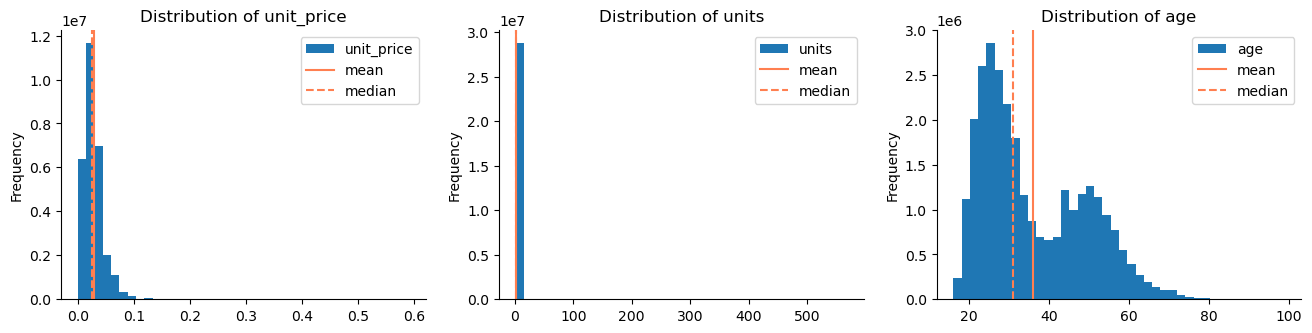

In [7]:
plt.subplots(1,3, figsize=(16,3.5))
for i, col in enumerate(numeric_df.columns):
    plt.subplot(1,3,i+1)
    numeric_df[col].plot(kind='hist', bins = 40)
    
    # plotting mean and median lines
    plt.axvline(numeric_df[col].mean(), 0, 2000, c='coral', label='mean')
    plt.axvline(numeric_df[col].median(), 0, 2000, c='coral', linestyle='--', label='median')
    
    sns.despine()
    plt.title(f'Distribution of {col}')
    plt.legend()
plt.show();   

- Unit price seems to be slightly skewed to the right. The price seems to be scaled already. 
- The majority of the units in each transactions is 1. Transactions are only aggregated with the number of units of each article. It cannot tell if a customer bought multiple different items in one order. We can retrieve this information by grouping t_dat and customer_id. The assumption here is a customer would only make one order maximum each day.
- Two age range can be identified with the most number of transactions: 23-33 and 45-55.

In [8]:
numeric_df['unit_price'].mean()

0.027728679892200424

In [9]:
numeric_df['units'].value_counts()

units
1      26269511
2       2285073
3        177237
4         55412
5          9259
         ...   
63            1
199           1
89            1
86            1
77            1
Name: count, Length: 75, dtype: int64

Let's look at the correlation of the numeric columns

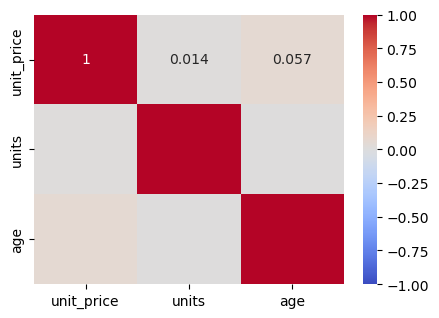

In [10]:
sns.heatmap(numeric_df.corr(),annot=True, cmap='coolwarm', vmin=-1, vmax=1);

The correlation between numeric variables are pretty close to 0. 

In [11]:
hm_sales.head()

t_dat                                        customer_id  article_id  \
0  2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   541518023   
1  2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   663713001   
2  2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   505221001   
3  2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   505221004   
4  2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   685687001   

   unit_price  units sales_channel                 prod_name  \
0    0.030492      1        Online   Rae Push (Melbourne) 2p   
1    0.050831      1        Online  Atlanta Push Body Harlow   
2    0.020322      1        Online               Inca Jumper   
3    0.015237      1        Online               Inca Jumper   
4    0.016932      1        Online      W YODA KNIT OL OFFER   

  product_type_name  product_group_name graphical_appearance_name  ...  \
0               Bra           Underwear                     Solid  ...   
1    Underwear body           Underwear                     Solid  ...   
2           Sweater  Garment Upper body                   Melange  ...   
3           Sweater  Garment Upper body                   Melange  ...   
4           Sweater  Garment Upper body                   Melange  ...   

  index_group_name                section_name garment_group_name  \
0       Ladieswear             Womens Lingerie  Under-, Nightwear   
1       Ladieswear             Womens Lingerie  Under-, Nightwear   
2          Divided            Divided Selected           Knitwear   
3          Divided            Divided Selected           Knitwear   
4       Ladieswear  Womens Everyday Collection     Special Offers   

                                         detail_desc     FN Active  \
0  Lace push-up bras with underwired, moulded, pa...  False  False   
1  Lace push-up body with underwired, moulded, pa...  False  False   
2  Jumper in rib-knit cotton with hard-worn detai...   True   True   
3  Jumper in rib-knit cotton with hard-worn detai...   True   True   
4  V-neck knitted jumper with long sleeves and ri...   True   True   

  club_member_status fashion_news_frequency   age  \
0             ACTIVE                   NONE  24.0   
1             ACTIVE                   NONE  24.0   
2             ACTIVE              Regularly  32.0   
3             ACTIVE              Regularly  32.0   
4             ACTIVE              Regularly  32.0   

                                         postal_code  
0  64f17e6a330a85798e4998f62d0930d14db8db1c054af6...  
1  64f17e6a330a85798e4998f62d0930d14db8db1c054af6...  
2  8d6f45050876d059c830a0fe63f1a4c022de279bb68ce3...  
3  8d6f45050876d059c830a0fe63f1a4c022de279bb68ce3...  
4  8d6f45050876d059c830a0fe63f1a4c022de279bb68ce3...  

[5 rows x 25 columns]

## N_transactions by product category

In [12]:
hm_sales.columns[7:18]

Index(['product_type_name', 'product_group_name', 'graphical_appearance_name',
       'colour_group_name', 'perceived_colour_value_name',
       'perceived_colour_master_name', 'department_name', 'index_name',
       'index_group_name', 'section_name', 'garment_group_name'],
      dtype='object')

We have 11 product related variables that can be used as segments.

In [13]:
hm_sales.iloc[:,7:18].nunique()

product_type_name               130
product_group_name               19
graphical_appearance_name        30
colour_group_name                50
perceived_colour_value_name       8
perceived_colour_master_name     20
department_name                 250
index_name                       10
index_group_name                  5
section_name                     56
garment_group_name               21
dtype: int64

For preliminary EDA we would like to look at a higher level category. In this case, We might want to look at product_group_name, index_name, or index_group_name.

Let's look into how classes are distributed among the three columns.

In [14]:
prod_seg = hm_sales[['product_group_name','index_name', 'index_group_name']]

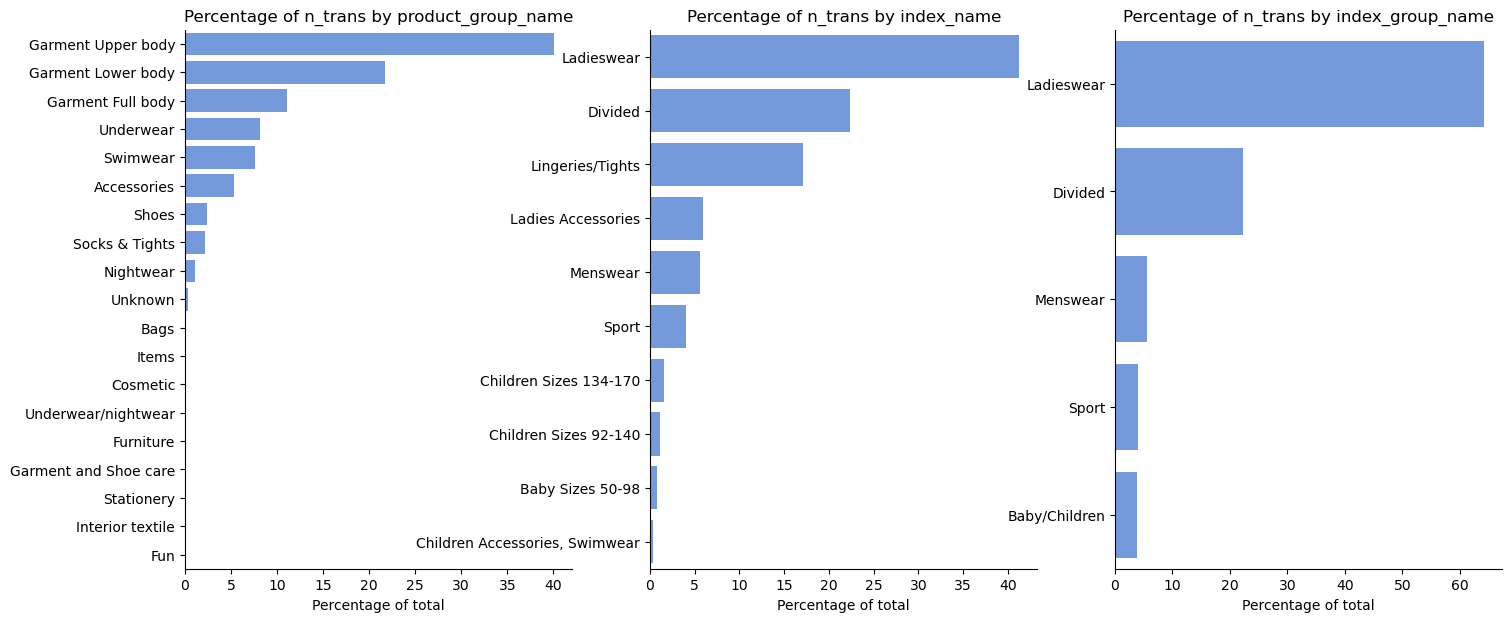

In [15]:
plt.subplots(1,3, figsize=(17,7))
for i, col in enumerate(prod_seg.columns):
    plt.subplot(1,3,i+1)
    j = prod_seg[col].value_counts(normalize=True).to_frame().reset_index()
    j['perc'] = j['proportion']*100
    
    # Plotting dist by segments
    sns.barplot(j, x='perc', y=col,
               color='cornflowerblue')
    sns.despine()
    plt.title(f'Percentage of n_trans by {col}')
    plt.xlabel('Percentage of total')
    plt.ylabel(None)

plt.show();  

- Hierarchies can be seen from categorical variables that is related to products, might need feature engineering.
- Over 60% of the transactions are **Ladieswaer** according to index_group_name.


In [16]:
prod_seg.groupby(['index_group_name', 'index_name']).count().sort_values(['index_group_name','product_group_name'], ascending=False)

product_group_name
index_group_name index_name                                        
Sport            Sport                                      1148763
Menswear         Menswear                                   1608839
Ladieswear       Ladieswear                                11882578
                 Lingeries/Tights                           4920372
                 Ladies Accessories                         1692785
Divided          Divided                                    6440803
Baby/Children    Children Sizes 134-170                      461455
                 Children Sizes 92-140                       319675
                 Baby Sizes 50-98                            239709
                 Children Accessories, Swimwear               98440

- **Ladieswear** and **Baby/Children** have subcategories.

## Time Series

To conduct time series EDA it would be easier if we set date as index first.

In [17]:
hm_sales['t_dat'] = pd.to_datetime(hm_sales['t_dat'])
hm_sales = hm_sales.set_index('t_dat')
hm_sales.head()

customer_id  article_id  \
t_dat                                                                       
2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   541518023   
2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   663713001   
2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   505221001   
2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   505221004   
2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   685687001   

            unit_price  units sales_channel                 prod_name  \
t_dat                                                                   
2018-09-20    0.030492      1        Online   Rae Push (Melbourne) 2p   
2018-09-20    0.050831      1        Online  Atlanta Push Body Harlow   
2018-09-20    0.020322      1        Online               Inca Jumper   
2018-09-20    0.015237      1        Online               Inca Jumper   
2018-09-20    0.016932      1        Online      W YODA KNIT OL OFFER   

           product_type_name  product_group_name graphical_appearance_name  \
t_dat                                                                        
2018-09-20               Bra           Underwear                     Solid   
2018-09-20    Underwear body           Underwear                     Solid   
2018-09-20           Sweater  Garment Upper body                   Melange   
2018-09-20           Sweater  Garment Upper body                   Melange   
2018-09-20           Sweater  Garment Upper body                   Melange   

           colour_group_name  ... index_group_name  \
t_dat                         ...                    
2018-09-20        Light Pink  ...       Ladieswear   
2018-09-20             Black  ...       Ladieswear   
2018-09-20              Grey  ...          Divided   
2018-09-20              Pink  ...          Divided   
2018-09-20         Dark Grey  ...       Ladieswear   

                          section_name garment_group_name  \
t_dat                                                       
2018-09-20             Womens Lingerie  Under-, Nightwear   
2018-09-20             Womens Lingerie  Under-, Nightwear   
2018-09-20            Divided Selected           Knitwear   
2018-09-20            Divided Selected           Knitwear   
2018-09-20  Womens Everyday Collection     Special Offers   

                                                  detail_desc     FN Active  \
t_dat                                                                         
2018-09-20  Lace push-up bras with underwired, moulded, pa...  False  False   
2018-09-20  Lace push-up body with underwired, moulded, pa...  False  False   
2018-09-20  Jumper in rib-knit cotton with hard-worn detai...   True   True   
2018-09-20  Jumper in rib-knit cotton with hard-worn detai...   True   True   
2018-09-20  V-neck knitted jumper with long sleeves and ri...   True   True   

           club_member_status fashion_news_frequency   age  \
t_dat                                                        
2018-09-20             ACTIVE                   NONE  24.0   
2018-09-20             ACTIVE                   NONE  24.0   
2018-09-20             ACTIVE              Regularly  32.0   
2018-09-20             ACTIVE              Regularly  32.0   
2018-09-20             ACTIVE              Regularly  32.0   

                                                  postal_code  
t_dat                                                          
2018-09-20  64f17e6a330a85798e4998f62d0930d14db8db1c054af6...  
2018-09-20  64f17e6a330a85798e4998f62d0930d14db8db1c054af6...  
2018-09-20  8d6f45050876d059c830a0fe63f1a4c022de279bb68ce3...  
2018-09-20  8d6f45050876d059c830a0fe63f1a4c022de279bb68ce3...  
2018-09-20  8d6f45050876d059c830a0fe63f1a4c022de279bb68ce3...  

[5 rows x 24 columns]

In [18]:
hm_sales_monthly = hm_sales[['customer_id', 'units']].resample('MS').count()
hm_sales_monthly.head()

customer_id    units
t_dat                           
2018-09-01       542680   542680
2018-10-01      1271899  1271899
2018-11-01      1158527  1158527
2018-12-01      1046956  1046956
2019-01-01      1127415  1127415

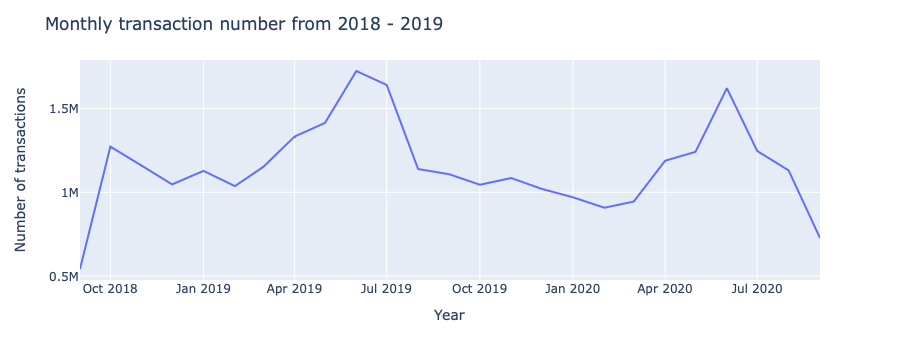

In [30]:
fig = px.line(hm_sales_monthly, x=hm_sales_monthly.index, y="units",)
fig.update_layout(
    yaxis_title="Number of transactions", 
    xaxis_title="Year",
    legend_title="", 
    title="Monthly transaction number from 2018 - 2019"
)
fig.show();

In [20]:
# fig.write_html('sales.html')

We can spot a seasonal trend here, with number of transactions peaked at June each year.

**Next Steps**

Here we breifly sum up the preliminary EDA with some future works:
- Feature Engineering Oppurtunities
    - Transactions are only aggregated with the number of units of each article. It cannot tell if a customer bought multiple different items in one order. We can retrieve this information by grouping t_dat and customer_id. The assumption here is a customer would only make one order maximum each day.
    - Hierarchies can be seen from categorical variables that is related to products, might need feature engineering.
    - As we are doing demand forecasting for the project, we need to create a lag feature of the time series
- More EDA
    - We haven't thoroughly look into all the categorical variables, maybe we can determine some key variables and drop those that are redundant after we figure out the hierarchies.
    - We may want to look into individual product groups and see if there are differences in customer demographics. (Kmeans)

The goal for the next step EDA is to determine which attributes effects sales (n_transactions) the most. We might come up with a plotly dashboard in the next step to grasp an overall picture of our data.

# EDA - Product Analysis and Preprocessing

In [21]:
hm_sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28813419 entries, 2018-09-20 to 2020-09-22
Data columns (total 24 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   customer_id                   object 
 1   article_id                    int64  
 2   unit_price                    float64
 3   units                         int64  
 4   sales_channel                 object 
 5   prod_name                     object 
 6   product_type_name             object 
 7   product_group_name            object 
 8   graphical_appearance_name     object 
 9   colour_group_name             object 
 10  perceived_colour_value_name   object 
 11  perceived_colour_master_name  object 
 12  department_name               object 
 13  index_name                    object 
 14  index_group_name              object 
 15  section_name                  object 
 16  garment_group_name            object 
 17  detail_desc                   object 
 18  FN    

## Product Categories

In [88]:
pc_cols = ['product_type_name','product_group_name', 'department_name', 'index_name', 'index_group_name', 'section_name', 'garment_group_name', 'prod_name']
for col in pc_cols:
    print(col)

product_type_name
product_group_name
department_name
index_name
index_group_name
section_name
garment_group_name
prod_name


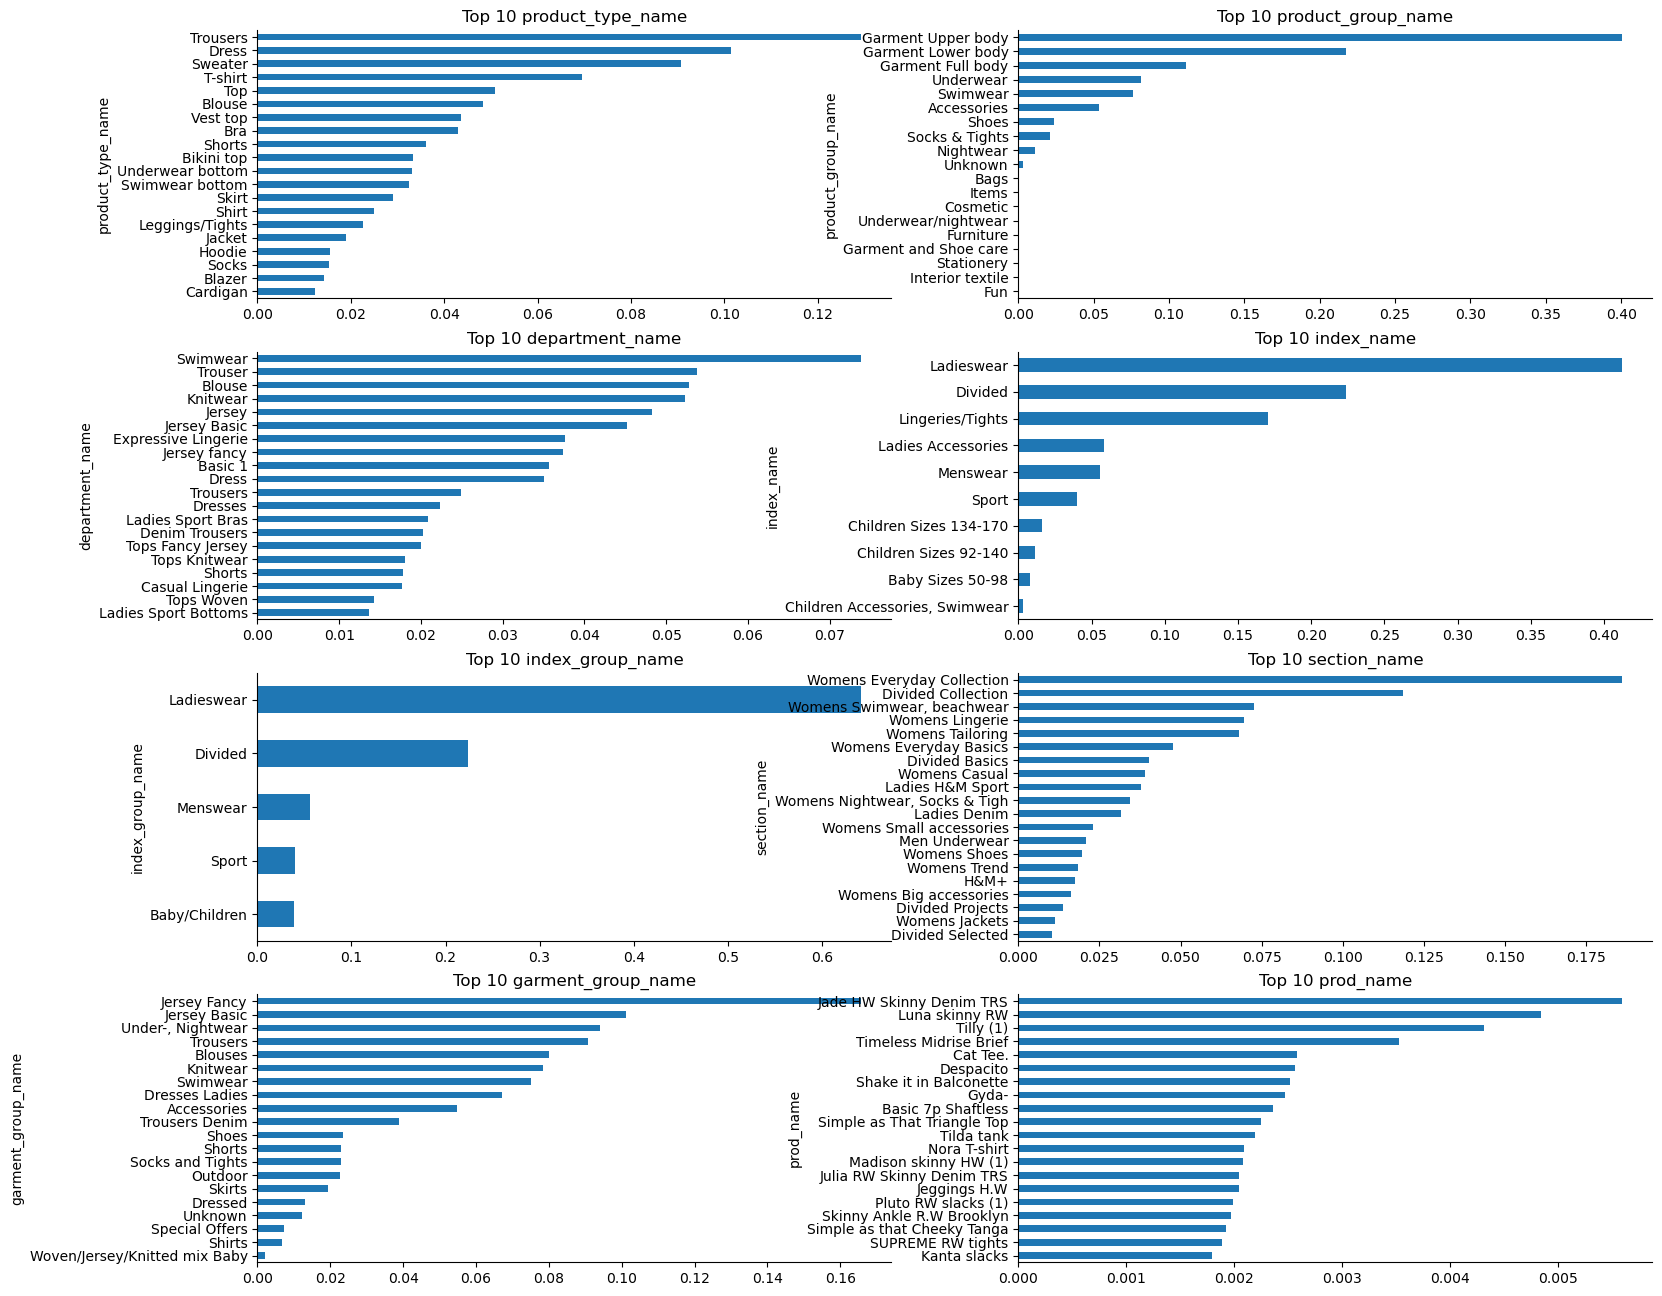

In [116]:
# Visualize appearance columns sort by n_transactions
plt.subplots(4, 2, figsize=(18,16))
for i, col in enumerate(pc_cols):
    plt.subplot(4, 2, i+1)
    hm_sales[col].value_counts(normalize=True).head(20).plot(kind='barh')
    plt.gca().invert_yaxis()
    plt.title(f'Top 10 {col}')
    # plt.xlabel('Percentage of Total')
    sns.despine()
plt.show();

We have 7 columns that is related with product categories, let's see the hierarchies in them:

### index_group_name v.s. index_name

As we've already seen in the previous EDA, we know that `index_group_name` has a subset called `index_name`

In [120]:
hm_sales.groupby('index_group_name')['index_name'].unique().reset_index()

index_group_name                                         index_name
0    Baby/Children  [Baby Sizes 50-98, Children Sizes 92-140, Chil...
1          Divided                                          [Divided]
2       Ladieswear  [Lingeries/Tights, Ladieswear, Ladies Accessor...
3         Menswear                                         [Menswear]
4            Sport                                            [Sport]

Here, `index_group_name` seems to be enough of the context we want. For simlicity we would want to drop `index_name`. Here we set a list for columns to be dropped and drop them at once later.

In [123]:
# Preprocess parameters - place holder for columns to be dropped
cols_to_drop = ['index_name']
cols_to_drop

['index_name']

### Product_group_name and product_type_name

Here we basically look at the two category and their relation ship with product name. We would like to know:
- How many products are within each product group?
- Is product_type_name a subset of product_group_name?
- Should we limit to only a few of the product groups for the scope of this project?

**How many products are within each product group**

In [136]:
product_group_count = hm_sales.groupby('product_group_name')['prod_name'].nunique().sort_values(ascending=False).reset_index().rename(columns={'prod_name':'n_unique_product'})
product_group_count['perc'] = product_group_count['n_unique_product']/hm_sales['prod_name'].nunique()
product_group_count

product_group_name  n_unique_product      perc
0      Garment Upper body             15904  0.368617
1      Garment Lower body              7853  0.182014
2       Garment Full body              6531  0.151373
3             Accessories              5986  0.138741
4                   Shoes              2522  0.058454
5               Underwear              1955  0.045312
6                Swimwear              1324  0.030687
7               Nightwear               636  0.014741
8          Socks & Tights               634  0.014695
9                 Unknown                61  0.001414
10               Cosmetic                30  0.000695
11                   Bags                17  0.000394
12              Furniture                13  0.000301
13                  Items                11  0.000255
14    Underwear/nightwear                10  0.000232
15  Garment and Shoe care                 9  0.000209
16       Interior textile                 3  0.000070
17                    Fun                 2  0.000046
18             Stationery                 1  0.000023

- Here we can see that a lot of product groups contains less than 1% of the total products. We would consider dropping them.

In [143]:
# shape before dropping the rows
hm_sales.shape

(28813419, 25)

In [142]:
# dropping the rows in groups with less than 1% product
product_group_list = product_group_count[product_group_count['perc'] > 0.01]['product_group_name'].to_list()

# shape after dropping the rows
hm_sales[hm_sales['product_group_name'].isin(product_group_list)].shape

(28712292, 25)

**Is product_type_name a subset of product_group_name**

In [146]:
hm_sales.groupby(['product_group_name', 'product_type_name'])['prod_name'].nunique().reset_index().head(10)

product_group_name product_type_name  prod_name
0        Accessories   Accessories set          3
1        Accessories        Alice band          6
2        Accessories          Baby Bib          1
3        Accessories               Bag        756
4        Accessories            Beanie         28
5        Accessories              Belt        279
6        Accessories          Bracelet        139
7        Accessories            Braces          2
8        Accessories        Bucket hat          7
9        Accessories               Cap          8

We can see that product_group_name is a superset of product_type_name. We will keep them both for now. Just a note that we might need further NLP with product type name.

Finally, as we have so many product in our data. We might want to limit the scope of this project to look at only a few groups from product group.

**Limit the scope of the project to a few product groups**

Let's look at categories within the product group 'Garment Upper body'

In [148]:
# Filter group Garment Upper body and print unique values of category columns
for col in pc_cols:
    print(f'-------- {col} ----------')
    print(hm_sales[hm_sales['product_group_name']=='Garment Upper body'][col].unique())

-------- product_type_name----------
['Sweater' 'Blouse' 'Cardigan' 'Vest top' 'T-shirt' 'Top' 'Shirt' 'Jacket'
 'Hoodie' 'Bodysuit' 'Polo shirt' 'Coat' 'Blazer' 'Tailored Waistcoat'
 'Outdoor Waistcoat']
-------- product_group_name----------
['Garment Upper body']
-------- department_name----------
['Tops Knitwear DS' 'Campaigns' 'Blouse' 'Tops Knitwear' 'Basic 1'
 'Projects Jersey & Knitwear' 'Jersey Fancy DS' 'Jersey'
 'Tops Fancy Jersey' 'Kids Boy Knitwear' 'Jersey fancy' 'Knitwear'
 'Ladies Sport Bras' 'Jersey Fancy' 'Kids Girl Jersey Fancy'
 'Kids Girl Knitwear' 'Young Girl Knitwear' 'Outwear' 'Jersey Basic'
 'Outdoor/Blazers' 'Kids Boy Jersey Fancy' 'Baby Girl Jersey Fancy'
 'Young Girl Jersey Basic' 'Knitwear Basic' 'Tops Woven' 'Suit jacket'
 'Suit' 'Kids Boy Outdoor' 'Loungewear' 'Jersey Occasion' 'Read & React'
 'Baby Exclusive' 'Woven top' 'Baby basics' 'Newborn' 'Woven Occasion'
 'Baby Girl Knitwear' 'Baby Boy Jersey Fancy' 'Baby Girl Woven'
 'Outdoor inactive from s1' 'Ja

We might want to drop department name as there seems to be too many false informatino stored with context irrelavant to the product category. Let's give it a check:

In [153]:
hm_sales[hm_sales['product_group_name']=='Garment Upper body'].groupby(['product_type_name','department_name'])['prod_name'].nunique().reset_index().head(10)

product_type_name                           department_name  prod_name
0            Blazer                      AK Dresses & Outdoor          5
1            Blazer                           Asia Assortment          1
2            Blazer                            Baby Boy Woven          1
3            Blazer                                    Blazer         90
4            Blazer                                Blazer S&T         44
5            Blazer                            Blouse & Dress          3
6            Blazer                      Boys Local Relevance          3
7            Blazer                                 Campaigns          3
8            Blazer                       Conscious Exclusive          4
9            Blazer  Denim wardrobe H&M man inactive from S.6         14

Also we check the same thing with garment_group_name.

In [154]:
hm_sales[hm_sales['product_group_name']=='Garment Upper body'].groupby(['product_type_name','garment_group_name'])['prod_name'].nunique().reset_index().head(10)

product_type_name             garment_group_name  prod_name
0            Blazer                        Blouses          4
1            Blazer                        Dressed        373
2            Blazer                 Dresses Ladies         13
3            Blazer                   Jersey Fancy          4
4            Blazer                        Outdoor         80
5            Blazer                         Shirts         38
6            Blazer                 Special Offers         12
7            Blazer                       Trousers          3
8            Blazer                        Unknown         48
9            Blazer  Woven/Jersey/Knitted mix Baby          1

For the simlicity of this project, I will make a call here to drop these to columns.o

In [156]:
# Update Preprocess parameters
cols_to_drop.append('department_name')
cols_to_drop.append('garment_group_name')
cols_to_drop

['index_name', 'department_name', 'garment_group_name']

As for the product groups to keep within the scope of this project, we refer to the sales with top 5 sales. As we are selecting only the product group with top 5 sales, we no longer need to remove the groups with less than 1% of total products.

In [164]:
# Preprocess parameters
groups_to_keep = hm_sales['product_group_name'].value_counts().head(5).index.to_list()
groups_to_keep

['Garment Upper body',
 'Garment Lower body',
 'Garment Full body',
 'Underwear',
 'Swimwear']

## Appearance - colours and graphical appearances

Let's look at some colors!

In [22]:
hm_sales['colour_group_name'].unique()

array(['Light Pink', 'Black', 'Grey', 'Pink', 'Dark Grey', 'Dark Green',
       'Dark Red', 'Turquoise', 'Light Beige', 'Yellow', 'Red',
       'Light Grey', 'White', 'Blue', 'Dark Blue', 'Dark Beige', 'Beige',
       'Light Orange', 'Light Purple', 'Off White', 'Greenish Khaki',
       'Other Pink', 'Dark Turquoise', 'Dark Pink', 'Greyish Beige',
       'Light Blue', 'Orange', 'Other Red', 'Dark Yellow', 'Light Yellow',
       'Light Turquoise', 'Green', 'Silver', 'Other Blue', 'Gold',
       'Dark Purple', 'Other', 'Dark Orange', 'Yellowish Brown',
       'Other Purple', 'Light Green', 'Other Orange', 'Other Green',
       'Purple', 'Light Red', 'Transparent', 'Other Yellow', 'Unknown',
       'Other Turquoise', 'Bronze/Copper'], dtype=object)

In [23]:
hm_sales['graphical_appearance_name'].unique()

array(['Solid', 'Melange', 'All over pattern', 'Check', 'Front print',
       'Placement print', 'Lace', 'Denim', 'Treatment', 'Stripe', 'Dot',
       'Contrast', 'Colour blocking', 'Jacquard', 'Other structure',
       'Embroidery', 'Other pattern', 'Glittering/Metallic', 'Neps',
       'Mixed solid/pattern', 'Application/3D', 'Transparent', 'Metallic',
       'Sequin', 'Chambray', 'Argyle', 'Unknown', 'Slub', 'Mesh',
       'Hologram'], dtype=object)

In [24]:
hm_sales['perceived_colour_value_name'].unique()

array(['Dusty Light', 'Dark', 'Medium Dusty', 'Medium', 'Bright', 'Light',
       'Undefined', 'Unknown'], dtype=object)

In [25]:
hm_sales['perceived_colour_master_name'].unique()

array(['Pink', 'Black', 'Unknown', 'Grey', 'Green', 'Red', 'Turquoise',
       'Beige', 'Yellow', 'White', 'Blue', 'Brown', 'Orange',
       'Lilac Purple', 'Khaki green', 'Mole', 'Metal', 'undefined',
       'Yellowish Green', 'Bluish Green'], dtype=object)

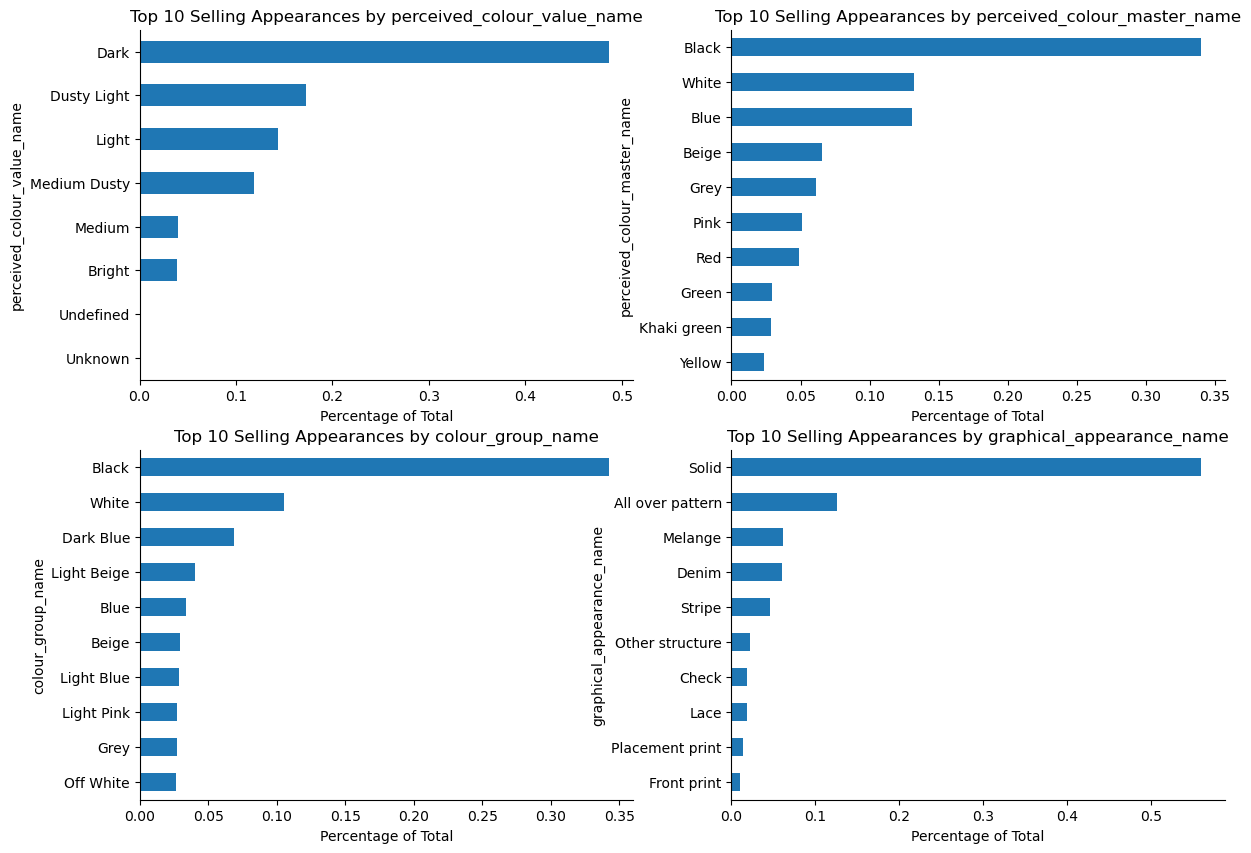

In [55]:
# select columns that are related to products appearance
appearance_cols = ['perceived_colour_value_name', 'perceived_colour_master_name', 'colour_group_name', 'graphical_appearance_name']

# Visualize appearance columns sort by n_transactions
plt.subplots(2, 2, figsize=(14,10))
for i, col in enumerate(appearance_cols):
    plt.subplot(2, 2, i+1)
    hm_sales[col].value_counts(normalize=True).head(10).plot(kind='barh')
    plt.gca().invert_yaxis()
    plt.title(f'Top 10 Selling Appearances by {col}')
    plt.xlabel('Percentage of Total')
    sns.despine()
plt.show();

**Notes**
- Black, white, blue, beige, and grey are the most selling colors, with black accumulating over 30% of total sales.
- Solid is a clear win in graphical appearance, with over 50% of total sales.
- We see that green, khak green, light blue, and light pink comes up in the top 10 as well, this might be an indicator of seasonal trend.
- Dark colours are more popular compared to lighter ones.

In [168]:
color_group = hm_sales.groupby(['perceived_colour_master_name', 'colour_group_name']).count().sort_values('perceived_colour_master_name')['customer_id'].reset_index()
color_group = color_group.rename(columns={'customer_id':'counts'})

In [175]:
color_group[color_group['perceived_colour_master_name']=='Khaki green']

perceived_colour_master_name colour_group_name  counts
60                  Khaki green        Dark Beige    4166
61                  Khaki green        Dark Green   68833
62                  Khaki green       Dark Yellow    5981
63                  Khaki green             Green   47285
64                  Khaki green    Greenish Khaki  695761
65                  Khaki green     Greyish Beige    3664

In [173]:
color_group[color_group['colour_group_name']=='White']

perceived_colour_master_name colour_group_name   counts
129                      Unknown             White    93477
139                        White             White  2942931

**Preprocess Notes**
- perceived_colour_master_name seems to be a superset for colour_group_name. We might want to keep the former one as it already conveys enough information.
- perceived_colour_value_name seems to have a large difference between light and dark. We might just want to transform it to column `is_dark` with boolean.

In [176]:
cols_to_drop.append('colour_group_name')
cols_to_drop

['index_name', 'department_name', 'garment_group_name', 'colour_group_name']

In [59]:
# create is_dark column
is_dark = np.where(hm_sales['perceived_colour_value_name']=='Dark', 1, 0)

# Sanity check
(is_dark==1).sum()/is_dark.shape[0]

0.4871882784892692

In [60]:
cols_to_drop.append('perceived_colour_value_name')
cols_to_drop

['index_name',
 'department_name',
 'garment_group_name',
 'colour_group_name',
 'perceived_colour_value_name',
 'perceived_colour_value_name']

## Preprocessing

Here, we omit our data based on the previous EDA with the following steps:  
- [X]  drop cols_to_drop
- [X]  drop product group with less than 1% of products
- [X]  select only a few product groups
- [X]  Add column is_dark

In [66]:
cols_to_drop = ['index_name', 'department_name', 'garment_group_name', 'colour_group_name', 'perceived_colour_value_name']
groups_to_keep =['Garment Upper body', 'Garment Lower body', 'Garment Full body', 'Underwear', 'Swimwear']

In [62]:
# Drop columns
print(f'columns before dropping: {hm_sales.shape[1]}')
hm_sales_processed = hm_sales.drop(cols_to_drop, axis=1)
print(f'columns after dropping: {hm_sales_processed.shape[1]}')

columns before dropping: 26
columns after dropping: 21


In [63]:
# Adding column is_dark
hm_sales_processed['is_dark'] = is_dark
hm_sales_processed.columns

Index(['t_dat', 'customer_id', 'article_id', 'unit_price', 'units',
       'is_online', 'product_id', 'prod_name', 'product_type_name',
       'product_group_name', 'graphical_appearance_name',
       'perceived_colour_master_name', 'index_group_name', 'section_name',
       'detail_desc', 'FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age', 'postal_code', 'is_dark'],
      dtype='object')

In [64]:
hm_sales_processed['is_dark'].value_counts(normalize=True)

is_dark
0    0.512812
1    0.487188
Name: proportion, dtype: float64

In [67]:
# Select only rows of interested product group
print(f'groups to keep :{groups_to_keep}')
print(f'rows before dropping: {hm_sales_processed.shape[0]}')
hm_sales_processed = hm_sales_processed[hm_sales_processed['product_group_name'].isin(groups_to_keep)]
print(f'rows after dropping: {hm_sales_processed.shape[0]}')

groups to keep :['Garment Upper body', 'Garment Lower body', 'Garment Full body', 'Underwear', 'Swimwear']
rows before dropping: 28813419
rows after dropping: 25547159


In [68]:
# number of product_types 
hm_sales_processed['product_type_name'].nunique()

43

We've successfully reduced product type within our scope while not reducing a lot of transactions. Next, we will look into sales analysis by number of transactions.

In [69]:
# Save the processed files. Blocked code in case running it by accident
# hm_sales_processed.to_csv('data/hm_sales_processed.csv', index=False)

In [4]:
# Uncomment code if u start from here
# hm_sales_processed = pd.read_csv('data/hm_sales_processed.csv')

# EDA - Sales Analysis (Time Series)

Here we are going to pick some of the top selling items, normalling selling items, and some of the items that perform not that well on sellings. We are going to explore the sales trend by time and see if there are similarities and differences for different performing products. Steps are as follows:

- [X] Pick items (`prod_name`) to explore:
    - [ ] (Binning the products by sales performance)
    - [X] Randomly select products from different tiers (let's say 3-5 products for each tiers)
- [X] Aggregate with WEEK cyclicity and visualize
- [ ] Find insights

### Analyzing top performing products

Let's start by doint it with one product, we can choose the top selling product as our example:

In [6]:
# selecting top selling product as sample_product
top_prod = hm_sales_processed['product_id'].mode().iloc[0]

# filter df
df = hm_sales_processed[hm_sales_processed['product_id']==top_prod]
name = df['prod_name'].unique()[0]
print(f'top product: {name}')

# Calculate the percentage of sales for this product compared to tatal
prod_sales_pct = round(df.shape[0]*100/ hm_sales_processed.shape[0],2)
print(f'Percentage of Sales: {prod_sales_pct}%')

# timeseries prep
df['t_dat']=pd.to_datetime(df['t_dat'])
df = df.set_index('t_dat')

# Keeping only units column
df = df.loc[:,['units']] 

# Aggregate by week
df = df.resample('W').sum()
df.T.head()

top product: Jade HW Skinny Denim TRS
Percentage of Sales: 0.63%


t_dat  2018-11-04  2018-11-11  2018-11-18  2018-11-25  2018-12-02  2018-12-09  \
units          10          32          41         149         373        1094   

t_dat  2018-12-16  2018-12-23  2018-12-30  2019-01-06  ...  2020-07-26  \
units        1141         913         956        1526  ...        2112   

t_dat  2020-08-02  2020-08-09  2020-08-16  2020-08-23  2020-08-30  2020-09-06  \
units        1774        1173        1224        1655        2185        2202   

t_dat  2020-09-13  2020-09-20  2020-09-27  
units        2619        1464         427  

[1 rows x 100 columns]

n_transactions for 'Jade HW Skinny Denim TRS' attributed 0.63% of total transactions. Let's visualize the sales over time for this product:

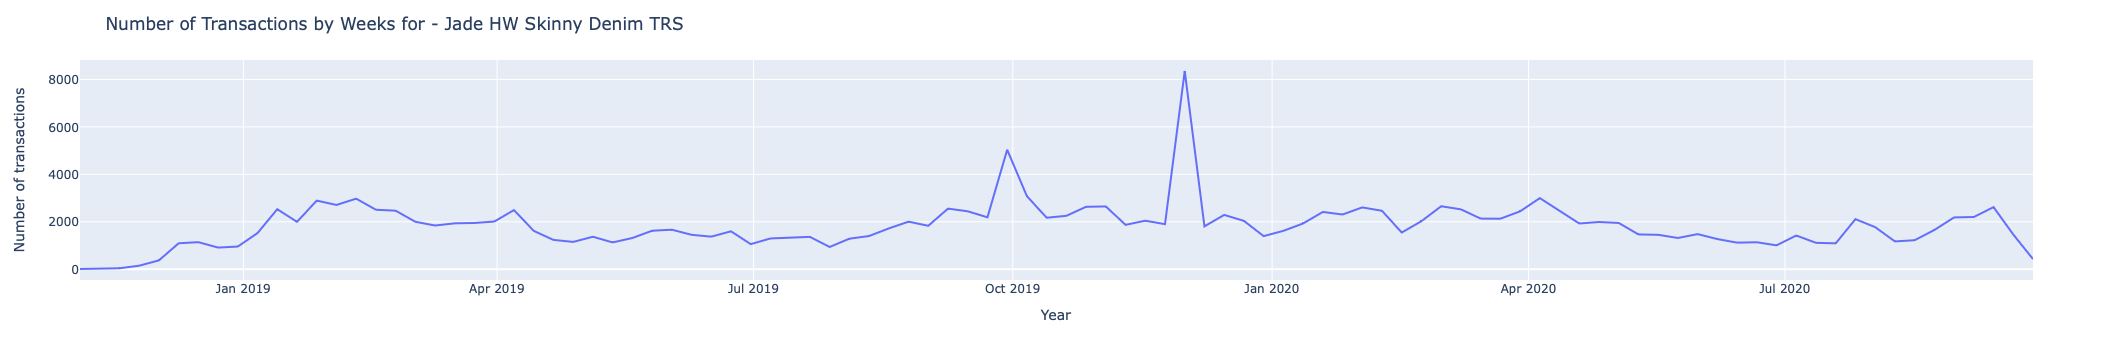

In [7]:
# looking at the sales for this product over time
fig = px.line(df, x=df.index, y="units",)
fig.update_layout(
    yaxis_title="Number of transactions", 
    xaxis_title="Year",
    legend_title="", 
    title=f"Number of Transactions by Weeks for - {name}"
)
fig.show();

We can observe obvious spikes during the week of '2019.09.29' and '2019.12.01'. Let's see if we can calculate weekly growth rate for the product.

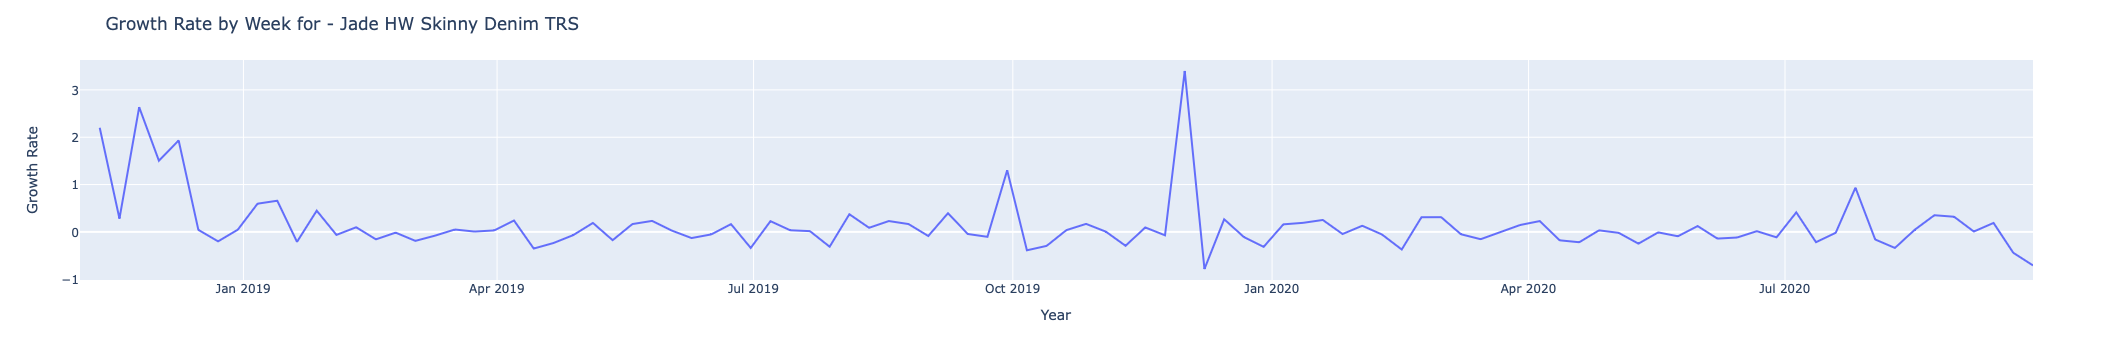

In [8]:
# Looking at percentage difference by weeks
df['%growth'] = df['units'].pct_change()

# Visualize growth % by time
fig = px.line(df, x=df.index, y="%growth",)
fig.update_layout(
    yaxis_title="Growth Rate", 
    xaxis_title="Year",
    legend_title="", 
    title=f"Growth Rate by Week for - {name}"
)
fig.show();

The growth rate does captures the two spikes that we were observing. However, we can see that the growth rate are also high in the beginning when we have less items.

### Analyzing selected random products

In [18]:
# selecting another sample product randomly
samp_prod =  hm_sales_processed['prod_name'].value_counts().reset_index().iloc[13894,0]
print(f'random product: {samp_prod}')

# filter df
df = hm_sales_processed[hm_sales_processed['prod_name'] == samp_prod]

# Calculate the percentage of sales for this product compared to tatal
prod_sales_pct = round(df.shape[0]*100/ hm_sales_processed.shape[0],4)
print(f'Percentage of Sales: {prod_sales_pct}%')

# timeseries prep
df['t_dat']=pd.to_datetime(df['t_dat'])
df = df.set_index('t_dat')

# Keeping only units column
df = df.loc[:,['units']] 

# Aggregate by week
df = df.resample('W').sum()
df.T.head()

random product: PE AGNES TOP 3
Percentage of Sales: 0.0007%


t_dat  2018-11-11  2018-11-18  2018-11-25  2018-12-02  2018-12-09  2018-12-16  \
units           1           0           4           4           4           1   

t_dat  2018-12-23  2018-12-30  2019-01-06  2019-01-13  ...  2019-10-06  \
units          16          15          19          21  ...           0   

t_dat  2019-10-13  2019-10-20  2019-10-27  2019-11-03  2019-11-10  2019-11-17  \
units           0           0           0           0           0           0   

t_dat  2019-11-24  2019-12-01  2019-12-08  
units           0           0           1  

[1 rows x 57 columns]

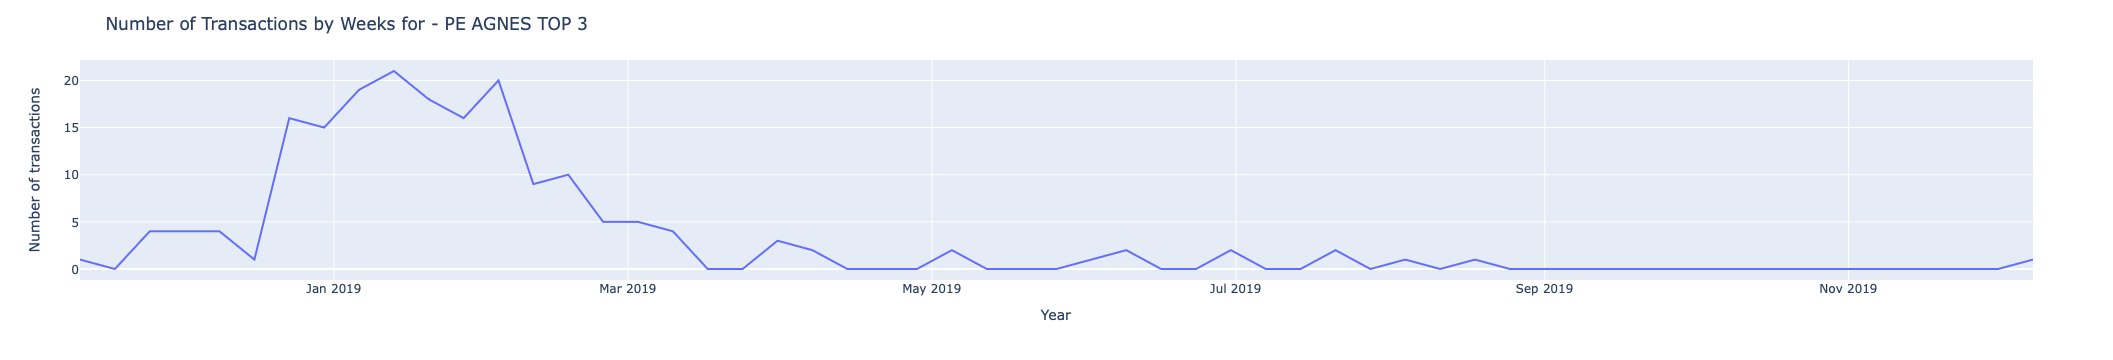

In [20]:
# looking at the sales for this product over time
fig = px.line(df, x=df.index, y="units",)
fig.update_layout(
    yaxis_title="Number of transactions", 
    xaxis_title="Year",
    legend_title="", 
    title=f"Number of Transactions by Weeks for - {samp_prod}"
)
fig.show();

In [21]:
# Looking at percentage difference by weeks
df['%growth'] = df['units'].pct_change()

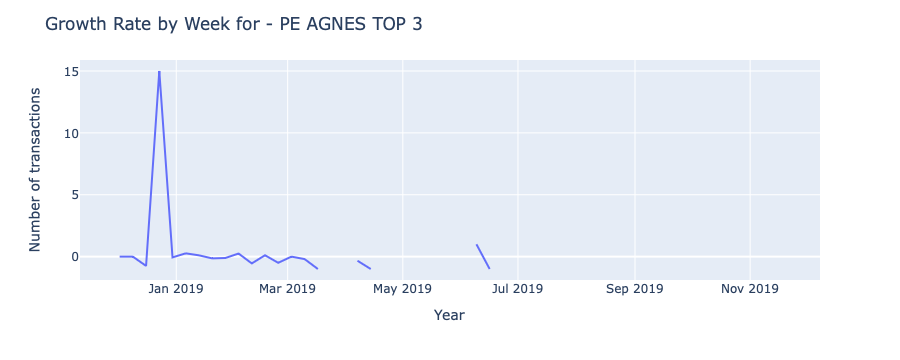

In [22]:
# Visualize growth % by time
fig = px.line(df, x=df.index, y="%growth",)
fig.update_layout(
    yaxis_title="Number of transactions", 
    xaxis_title="Year",
    legend_title="", 
    title=f"Growth Rate by Week for - {samp_prod}"
)
fig.show();

Here we do see some gaps in the growth rate, that's because there are weeks that have 0 sales. We mights want to deal with this. we can set growth rate as 0 for those missing values.

In [23]:
# replace growth rate with NaN and inf, -inf as 0
df['%growth'] = np.where((df['%growth'].isna()) | (df['%growth'].isin([float('inf'), float('-inf')])), 0, df['%growth'])

# Sanity check
print(df.isna().sum())
print((df['%growth'].isin([float('inf'), float('-inf')])).sum())

units      0
%growth    0
dtype: int64
0


Let's visualize the growth again:

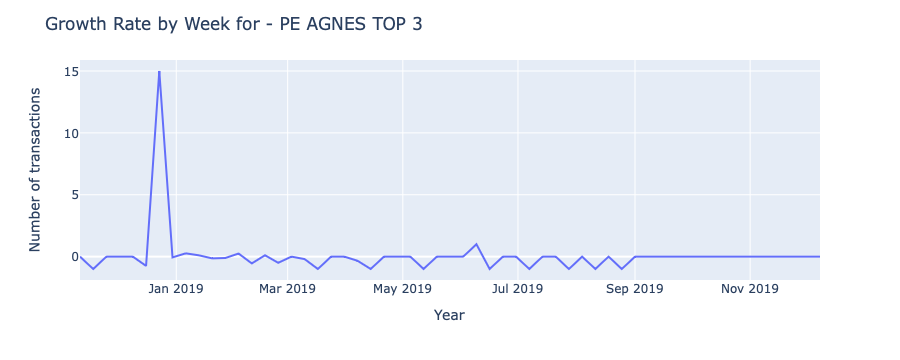

In [24]:
# Visualize growth % by time
fig = px.line(df, x=df.index, y="%growth",)
fig.update_layout(
    yaxis_title="Number of transactions", 
    xaxis_title="Year",
    legend_title="", 
    title=f"Growth Rate by Week for - {samp_prod}"
)
fig.show();

# Feature Engineering

## Target Variable - Trending

For our target variable "trending", we are going to engineer it with our dataset, it is going to be a boolean value of whether it has a spike in sales (threshold calculated by the growth percentage from last week) in the product life time.

We will use the calculation of '%growth' in the previous sections to achieve this.

In [5]:
hm_sales_processed.columns

Index(['t_dat', 'customer_id', 'article_id', 'unit_price', 'units',
       'is_online', 'product_id', 'prod_name', 'product_type_name',
       'product_group_name', 'graphical_appearance_name',
       'perceived_colour_master_name', 'index_group_name', 'section_name',
       'detail_desc', 'FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age', 'postal_code', 'is_dark'],
      dtype='object')

In [6]:
def weekly_sales_by_prod(df):
    # timeseries prep
    df['t_dat']=pd.to_datetime(df['t_dat'])
    df = df.set_index('t_dat')
    
    # Keeping only units column
    df = df.loc[:,['product_id','units']] 
    
    # Resample the DataFrame on a weekly basis, summing the values for each product
    weekly_resampled = df.groupby('product_id').resample('W').sum()
    weekly_resampled = weekly_resampled.drop(weekly_resampled.columns[0], axis=1) 

    # Calculate the weekly growth rate for each product
    pct_diff = weekly_resampled.groupby('product_id')['units'].pct_change() * 100

    # replace growth rate with NaN and inf, -inf as 0
    weekly_resampled['pct_diff'] = np.where((pct_diff.isna()) | (pct_diff.isin([float('inf'), float('-inf')])), 0, pct_diff)
    
    return weekly_resampled

In [7]:
weekly_resampled = weekly_sales_by_prod(hm_sales_processed)
weekly_resampled.head()

units    pct_diff
product_id t_dat                        
108775     2018-09-23    193    0.000000
           2018-09-30    811  320.207254
           2018-10-07    499  -38.471023
           2018-10-14    559   12.024048
           2018-10-21    398  -28.801431

In [8]:
# Add a lagged column for each product and calulate pct_diff (just the same as pct_change())
# weekly_resampled['lagged_value'] = weekly_resampled.groupby('product_id')['units'].shift(1)
# weekly_resampled['pct_diff'] = ((weekly_resampled['units']/weekly_resampled['lagged_value'])-1)*100

units_threshold = 200
pct_diff_threshold = 100

# Assuming 'units' and 'pct_diff' are columns in your DataFrame
product_trending = weekly_resampled.groupby('product_id').max()

# Create a 'trending' column based on conditions
product_trending['trending'] = (product_trending['units'] >= units_threshold)  & (product_trending['pct_diff'] >= pct_diff_threshold)

# Count the occurrences of True in the 'trending' column
trending_counts = product_trending['trending'].value_counts(normalize=True)

# Display the counts
print(trending_counts)

trending
False    0.894152
True     0.105848
Name: proportion, dtype: float64


Looks like we have around 10% of products being labeled 'trending' with our threshold set to 200 for weekly sales and 100% week-over-week growth. We can take a look at these trending items:

In [46]:
# Specify function for visualizing single product sales
def plot_sales(prod):

    # This function will visualize the sales over time for a single product
    # Input: product_id
    # Output: a plotly line plot for the sales over time for the input product_id

    # filter df
    df = hm_sales_processed[hm_sales_processed['product_id']== prod]
    name = df['prod_name'].unique()[0]
    # print(f'Product Name: {name}')
    
    # Calculate the percentage of sales for this product compared to tatal
    prod_sales_pct = round(df.shape[0]*100/ hm_sales_processed.shape[0],2)
    # print(f'Percentage of Sales: {prod_sales_pct}%')
    
    # timeseries prep
    df['t_dat']=pd.to_datetime(df['t_dat'])
    df = df.set_index('t_dat')
    
    # Keeping only units column
    df = df.loc[:,['units']] 
    
    # Aggregate by week
    df = df.resample('W').sum()

    # Looking at percentage difference by weeks
    df['perc_diff'] = round(df['units'].pct_change()*100,2)
    
    # replace growth rate with NaN and inf, -inf as 0
    df['perc_diff'] = np.where((df['perc_diff'].isna()) | (df['perc_diff'].isin([float('inf'), float('-inf')])), 0, df['perc_diff'])

    
    # looking at the sales for this product over time
    fig = px.line(df, x=df.index, y="units", hover_name=df.index, hover_data=['perc_diff'])
    fig.update_layout(
        yaxis_title="Number of transactions", 
        xaxis_title="Year",
        legend_title="", 
        title=f"Number of Transactions by Weeks for - {name}"
    )
    return fig

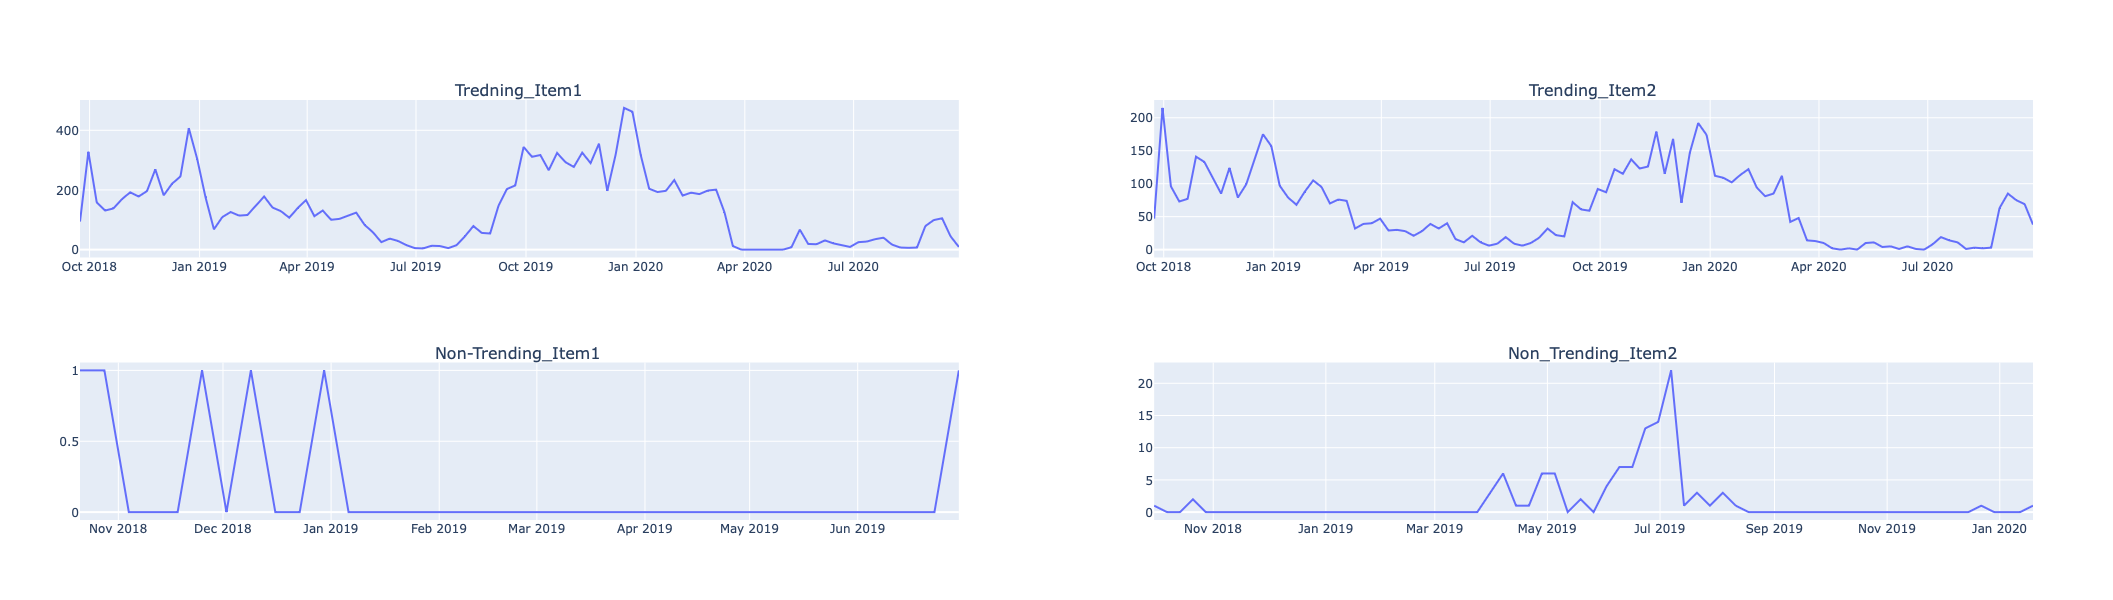

In [47]:
fig = make_subplots(rows=2, cols=2,
                   subplot_titles=['Tredning_Item1', 'Trending_Item2', 'Non-Trending_Item1','Non_Trending_Item2'],
                   column_widths=[0.9, 0.9])

prods = product_trending[product_trending['trending']==True].index[1:3]
for i, p in enumerate(prods):
    temp = plot_sales(p)
    fig.add_trace(temp['data'][0], row=1, col=i+1)

prods = product_trending[product_trending['trending']==False].index[1:3]
for i, p in enumerate(prods):
    temp = plot_sales(p)
    fig.add_trace(temp['data'][0], row=2, col=i+1)

# Update layout settings
fig.update_layout(showlegend=False, height=600, width=1200)  

# Show the subplot figure
fig.show()

Looks like these product does have times where there are high in sales. Although there are some limitations in this method in detecting trending items, such as capturing incorrect trending for certain items with high growth in the beginning of the launch. We will us it as our target variable for now.

## Product Table Aggregation

Essentially our model input is going to include product related features only, we will not be including sales related information here since our target variable is a calculation of sales, we don't want to induce bias here. Let's bring back the product related variables and prepare them for modeling.

In [73]:
hm_sales_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25547159 entries, 0 to 25547158
Data columns (total 22 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   t_dat                         datetime64[ns]
 1   customer_id                   object        
 2   article_id                    int64         
 3   unit_price                    float64       
 4   units                         int64         
 5   is_online                     int64         
 6   product_id                    int64         
 7   prod_name                     object        
 8   product_type_name             object        
 9   product_group_name            object        
 10  graphical_appearance_name     object        
 11  perceived_colour_master_name  object        
 12  index_group_name              object        
 13  section_name                  object        
 14  detail_desc                   object        
 15  FN                            

Let's construct the actual data frame that will be used for modelling, turning this data by transaction to a dataframe that is unique by product_id.

In [9]:
# Identify product relate columns
prod_columns = hm_sales_processed.columns[6:15].to_list()
prod_columns.append('unit_price')
prod_columns

['product_id',
 'prod_name',
 'product_type_name',
 'product_group_name',
 'graphical_appearance_name',
 'perceived_colour_master_name',
 'index_group_name',
 'section_name',
 'detail_desc',
 'unit_price']

In [10]:
# Select only product relate columns from the hm_sales
prod_df = hm_sales_processed[prod_columns]
prod_df.shape

(25547159, 10)

In [11]:
# Checking if each product_id correspond to one feature
uni_df = prod_df.groupby('product_id').nunique()
uni_df.describe()

prod_name  product_type_name  product_group_name  \
count    36203.0       36203.000000        36203.000000   
mean         1.0           1.004668            1.000773   
std          0.0           0.068165            0.027800   
min          1.0           1.000000            1.000000   
25%          1.0           1.000000            1.000000   
50%          1.0           1.000000            1.000000   
75%          1.0           1.000000            1.000000   
max          1.0           2.000000            2.000000   

       graphical_appearance_name  perceived_colour_master_name  \
count               36203.000000                  36203.000000   
mean                    1.287932                      1.916802   
std                     0.620636                      1.372034   
min                     1.000000                      1.000000   
25%                     1.000000                      1.000000   
50%                     1.000000                      1.000000   
75%                     1.000000                      2.000000   
max                     8.000000                     16.000000   

       index_group_name  section_name   detail_desc    unit_price  
count      36203.000000  36203.000000  36203.000000  36203.000000  
mean           1.001630      1.004005      0.996437     57.161202  
std            0.040337      0.064029      0.059587     95.171768  
min            1.000000      1.000000      0.000000      1.000000  
25%            1.000000      1.000000      1.000000      6.000000  
50%            1.000000      1.000000      1.000000     20.000000  
75%            1.000000      1.000000      1.000000     64.000000  
max            2.000000      3.000000      1.000000   1468.000000

Aside from graphical_appearnace_name, perceived_colour_master_name, and unit_price, features should have only 1 unique values corresponds to a product_id. We can see that there are product_id that has two or more product_type_name, product_group_name, index_group_name, and section_name. Let's take a look at those:

In [12]:
item_list = uni_df[uni_df['product_type_name']>1].index.to_list()
prod_df[prod_df['product_id'].isin(item_list)].sort_values('product_id').tail()

product_id                prod_name product_type_name  \
25178805      935196  PQ STAR SILK MIX TIGHTS          Trousers   
25177823      935196  PQ STAR SILK MIX TIGHTS   Leggings/Tights   
25405363      935196  PQ STAR SILK MIX TIGHTS          Trousers   
25187311      935196  PQ STAR SILK MIX TIGHTS   Leggings/Tights   
25151038      935196  PQ STAR SILK MIX TIGHTS   Leggings/Tights   

          product_group_name graphical_appearance_name  \
25178805  Garment Lower body                     Solid   
25177823  Garment Lower body                     Solid   
25405363  Garment Lower body                     Solid   
25187311  Garment Lower body                     Solid   
25151038  Garment Lower body                     Solid   

         perceived_colour_master_name index_group_name    section_name  \
25178805                    Turquoise       Ladieswear  Womens Premium   
25177823                        Black       Ladieswear  Womens Premium   
25405363                    Turquoise       Ladieswear  Womens Premium   
25187311                        Black       Ladieswear  Womens Premium   
25151038                        Black       Ladieswear  Womens Premium   

                                                detail_desc  unit_price  
25178805  Pair of airy, ribbed leggings in a soft silk b...    0.084729  
25177823  Pair of airy, ribbed leggings in a soft silk b...    0.084729  
25405363  Pair of airy, ribbed leggings in a soft silk b...    0.084729  
25187311  Pair of airy, ribbed leggings in a soft silk b...    0.083136  
25151038  Pair of airy, ribbed leggings in a soft silk b...    0.084729

Here we can see some mislabeling issue, let's deal with this by replacing the correct value by the mode of all of the same product.

In [13]:
# Assigning only the most frequent name to each code
col = 'product_type_name'
prod_categories_mode = prod_df.groupby('product_id')[col].agg(lambda x: pd.Series.mode(x)[0]).to_frame().reset_index()
prod_categories_mode


# Replace the col (category) (each product_id should have only one category)
product_ref = prod_df[['product_id']].copy()
product_ref = product_ref.merge(prod_categories_mode, how='left', on='product_id')

In [14]:
product_ref[product_ref['product_id'].isin(item_list)].sort_values('product_id').tail()

product_id product_type_name
25178805      935196   Leggings/Tights
25177823      935196   Leggings/Tights
25405363      935196   Leggings/Tights
25187311      935196   Leggings/Tights
25151038      935196   Leggings/Tights

**Todos:**

- Looks like it works! We will do a for loop and replace all the columns with miss labelling.
- Here, since around 80% of the graphical_appearance_name also have only 1 unique value, we wll apply this method to it as well.
- Let's drop the color column for now, we might want to bring it back as dummies later after establishing our baseline model.
- On the other hand, we can aggregate the unit_price with mode as well.

In [112]:
uni_df['graphical_appearance_name'].value_counts(normalize=True)

graphical_appearance_name
1    0.777836
2    0.174184
3    0.035301
4    0.008729
5    0.003011
6    0.000746
7    0.000166
8    0.000028
Name: proportion, dtype: float64

In [15]:
# Looping through columns with duplicated categories
cols = ['product_type_name', 'product_group_name', 'index_group_name', 'section_name', 'graphical_appearance_name', 'unit_price']

# Placeholder for cleaned columns
product_ref = prod_df[['product_id']].copy()


for col in cols:
    # Assigning only the most frequent name to each code
    prod_categories_mode = prod_df.groupby('product_id')[col].agg(lambda x: pd.Series.mode(x)[0]).to_frame().reset_index()
    
    # Replace the col (category) (each product_id should have only one category)
    product_ref = product_ref.merge(prod_categories_mode, how='left', on='product_id')

product_ref

product_id product_type_name  product_group_name index_group_name  \
0             541518               Bra           Underwear       Ladieswear   
1             663713    Underwear body           Underwear       Ladieswear   
2             505221           Sweater  Garment Upper body          Divided   
3             505221           Sweater  Garment Upper body          Divided   
4             685687           Sweater  Garment Upper body       Ladieswear   
...              ...               ...                 ...              ...   
25547154      856440             Dress   Garment Full body          Divided   
25547155      896169          Cardigan  Garment Upper body       Ladieswear   
25547156      910949               Bra           Underwear            Sport   
25547157      929511             Dress   Garment Full body          Divided   
25547158      898573            Blouse  Garment Upper body       Ladieswear   

                        section_name graphical_appearance_name  unit_price  
0                    Womens Lingerie                     Solid    0.030492  
1                    Womens Lingerie                     Solid    0.050831  
2                   Divided Selected                   Melange    0.020322  
3                   Divided Selected                   Melange    0.020322  
4         Womens Everyday Collection                   Melange    0.016932  
...                              ...                       ...         ...  
25547154          Divided Collection                     Solid    0.042356  
25547155  Womens Everyday Collection                   Melange    0.050831  
25547156            Ladies H&M Sport                     Solid    0.050831  
25547157          Divided Collection          All over pattern    0.059305  
25547158  Womens Everyday Collection                     Solid    0.033881  

[25547159 rows x 7 columns]

In [16]:
# Sanity check again - checking if each product_id correspond to one feature
uni_df = product_ref.groupby('product_id').nunique()
uni_df.describe()

product_type_name  product_group_name  index_group_name  section_name  \
count            36203.0             36203.0           36203.0       36203.0   
mean                 1.0                 1.0               1.0           1.0   
std                  0.0                 0.0               0.0           0.0   
min                  1.0                 1.0               1.0           1.0   
25%                  1.0                 1.0               1.0           1.0   
50%                  1.0                 1.0               1.0           1.0   
75%                  1.0                 1.0               1.0           1.0   
max                  1.0                 1.0               1.0           1.0   

       graphical_appearance_name  unit_price  
count                    36203.0     36203.0  
mean                         1.0         1.0  
std                          0.0         0.0  
min                          1.0         1.0  
25%                          1.0         1.0  
50%                          1.0         1.0  
75%                          1.0         1.0  
max                          1.0         1.0

Sweet! All max are 1. Looks like we can start replacing the columns.

In [159]:
(prod_df['product_id']!=product_ref['product_id']).sum()

0

In [17]:
# Merging product_ref back to the prod_df, dropping the color column here as well
prod_df = prod_df.drop(['product_type_name', 'product_group_name', 'index_group_name', 'section_name', 'graphical_appearance_name', 'unit_price', 'perceived_colour_master_name'], axis=1)
product_ref = product_ref.drop('product_id', axis=1)
prod_df = pd.concat([prod_df, product_ref], axis=1)
prod_df.shape

(25547159, 9)

In [18]:
# Sanity check again - checking if each product_id correspond to one feature
uni_df = prod_df.groupby('product_id').nunique()
uni_df.describe()

prod_name   detail_desc  product_type_name  product_group_name  \
count    36203.0  36203.000000            36203.0             36203.0   
mean         1.0      0.996437                1.0                 1.0   
std          0.0      0.059587                0.0                 0.0   
min          1.0      0.000000                1.0                 1.0   
25%          1.0      1.000000                1.0                 1.0   
50%          1.0      1.000000                1.0                 1.0   
75%          1.0      1.000000                1.0                 1.0   
max          1.0      1.000000                1.0                 1.0   

       index_group_name  section_name  graphical_appearance_name  unit_price  
count           36203.0       36203.0                    36203.0     36203.0  
mean                1.0           1.0                        1.0         1.0  
std                 0.0           0.0                        0.0         0.0  
min                 1.0           1.0                        1.0         1.0  
25%                 1.0           1.0                        1.0         1.0  
50%                 1.0           1.0                        1.0         1.0  
75%                 1.0           1.0                        1.0         1.0  
max                 1.0           1.0                        1.0         1.0

In [19]:
uni_df.shape

(36203, 8)

In [20]:
# Getting the product table with unique product_id
prod_df = prod_df.drop_duplicates()
prod_df.shape

(36203, 9)

In [21]:
# Merging the data with our target - trending
target = product_trending.reset_index()
target = target.rename(columns={'units':'max_units', 'pct_diff':'max_growth'})

prod_df = prod_df.merge(target, on='product_id', how='left')
prod_df.shape

(36203, 12)

We will be dropping max_units and max_growth since these two variables leaks information for our target variable.

In [22]:
# Dropping max_units and max_growth
prod_df = prod_df.drop(['max_units', 'max_growth'], axis=1)

Let's check for NaNs in prod_df:

In [23]:
prod_df.isna().sum()

product_id                     0
prod_name                      0
detail_desc                  129
product_type_name              0
product_group_name             0
index_group_name               0
section_name                   0
graphical_appearance_name      0
unit_price                     0
trending                       0
dtype: int64

For detail_desc, we might want to do vectorization. Before vectorizing, we need to impute the missing value for detail_desc:

In [24]:
prod_df['detail_desc'] = prod_df['detail_desc'].fillna(' ')

In [25]:
# Sanity check
prod_df['detail_desc'].isna().sum()

0

In [26]:
# Save the product table. Blocked code in case running it by accident
# prod_df.to_csv('data/prod_df.csv', index=False)

In [27]:
prod_df.head()

product_id                 prod_name  \
0      541518   Rae Push (Melbourne) 2p   
1      663713  Atlanta Push Body Harlow   
2      505221               Inca Jumper   
3      685687      W YODA KNIT OL OFFER   
4      501323      Thomas paperbag wide   

                                         detail_desc product_type_name  \
0  Lace push-up bras with underwired, moulded, pa...               Bra   
1  Lace push-up body with underwired, moulded, pa...    Underwear body   
2  Jumper in rib-knit cotton with hard-worn detai...           Sweater   
3  V-neck knitted jumper with long sleeves and ri...           Sweater   
4  Trousers in woven fabric with a high, paper ba...          Trousers   

   product_group_name index_group_name                section_name  \
0           Underwear       Ladieswear             Womens Lingerie   
1           Underwear       Ladieswear             Womens Lingerie   
2  Garment Upper body          Divided            Divided Selected   
3  Garment Upper body       Ladieswear  Womens Everyday Collection   
4  Garment Lower body       Ladieswear            Womens Tailoring   

  graphical_appearance_name  unit_price  trending  
0                     Solid    0.030492      True  
1                     Solid    0.050831     False  
2                   Melange    0.020322     False  
3                   Melange    0.016932      True  
4                     Check    0.059305      True

## Input Features

Finally, we will continue with feature engineering our variables.

In [4]:
# Read if start from here
# prod_df= pd.read_csv('data/prod_df.csv')

### One-Hot Encoding

In [29]:
prod_df.columns

Index(['product_id', 'prod_name', 'detail_desc', 'product_type_name',
       'product_group_name', 'index_group_name', 'section_name',
       'graphical_appearance_name', 'unit_price', 'trending'],
      dtype='object')

In [30]:
categorical_columns = ['product_type_name', 'product_group_name', 'index_group_name', 'section_name', 'graphical_appearance_name']
df_encoded = pd.get_dummies(prod_df, columns=categorical_columns, drop_first=True)
df_encoded.shape

(36203, 132)

### Vectorization

We have a product description column, we can vectorize this feature for modelling. Here we will also vectorize the product name.

In [31]:
# Spliting features X and target y (Reviewer Score)
X = df_encoded.drop('trending', axis=1)
y = df_encoded['trending']
print(X.shape, y.shape)

(36203, 131) (36203,)


In [32]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)
print(X_train.shape, X_test.shape)

(28962, 131) (7241, 131)


Let's split the X_train, X_test into positive reviews, negative reviews, and other.

In [33]:
# Splitting X_train and X_test into desired 3 tables
X_train_name = X_train['prod_name']
X_train_desc = X_train['detail_desc']
X_train_og = X_train.drop(columns=['prod_name', 'detail_desc'], axis=1)

X_test_name = X_test['prod_name']
X_test_desc = X_test['detail_desc']
X_test_og = X_test.drop(columns=['prod_name', 'detail_desc'], axis=1)

Now that we have them separated, we can continue to deal with the reviews and leave the others aside for now. 

In [34]:
X_train_name.value_counts(sort=True, ascending=False)[0:10]

prod_name
Molly dress         7
Bella dress         6
Dolly dress         6
Bowie               6
Ruby                6
Daisy               6
Melrose             6
Rose                5
Presley PU skirt    5
Cora                5
Name: count, dtype: int64

In [35]:
X_train_desc.value_counts(sort=True, ascending=False)[0:10]

detail_desc
                                                                                                          100
T-shirt in printed cotton jersey.                                                                          18
Boxer shorts in a cotton weave with an elasticated waist, long legs and button fly.                        12
Leggings in soft cotton jersey with an elasticated waist.                                                  12
T-shirt in soft cotton jersey with a print motif on the front.                                             10
T-shirt in cotton jersey with a print motif on the front.                                                  10
Leggings in soft organic cotton jersey with an elasticated waist.                                          10
Trunks in stretch cotton jersey with flatlock seams, short legs, an elasticated waist and lined front.     10
Boxer shorts in cotton jersey with short legs, an elasticated waist and lined front.                       1

Let's get our custom tokenizer.

**Tokenizer - Custom - Lemmatization**

In [36]:
# Custom tokenizer using lemmatizing
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


lemmatizer = WordNetLemmatizer()

ENGLISH_STOP_WORDS = stopwords.words('english')
# Include words we want to clean in stop words
ENGLISH_STOP_WORDS.extend(['none','no', 'nothing','n','a','negative','positive'])

def my_lemma_tokenizer(sentence):
    # # remove punctuation, numbers, and set to lower case
    # sentence = re.sub(r'[^a-zA-Z\s]', '', sentence).lower()
    
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    pos_tags = nltk.pos_tag(listofwords)
    listoflemmatized_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word, tag in pos_tags:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Lemmatized words
            
            lemmatized_word = lemmatizer.lemmatize(word,get_wordnet_pos(tag))
            listoflemmatized_words.append(lemmatized_word)

    return listoflemmatized_words

**Vectorize with TF-IDF**

In [37]:
# Fitting tfidf for product_name with Lemmatization
tfidf_name = TfidfVectorizer(max_features=500,
                                 min_df=10,
                                 tokenizer=my_lemma_tokenizer,
                                 ngram_range=(1, 3))
tfidf_name.fit(X_train_name)

X_train_name_transformed = tfidf_name.transform(X_train_name)
X_test_name_transformed = tfidf_name.transform(X_test_name)

X_train_name_transformed.shape

(28962, 500)

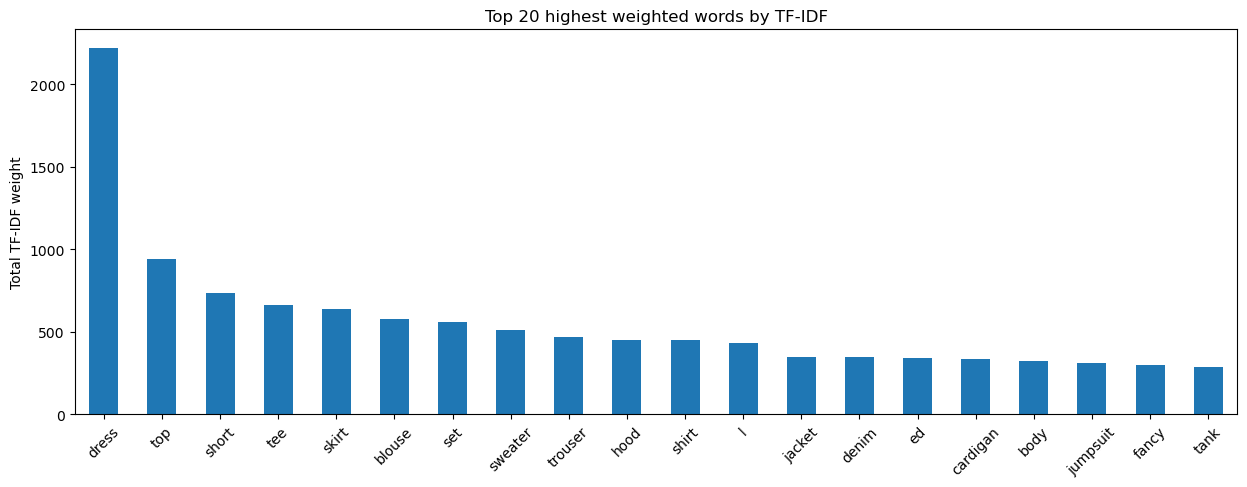

In [38]:
# Visualizing top 20 weighted words for product_name
word_counts = pd.DataFrame(
    {"counts": X_train_name_transformed.toarray().sum(axis=0)},
    index=tfidf_name.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 highest weighted words by TF-IDF")
plt.ylabel('Total TF-IDF weight')
plt.xticks(rotation=45)
plt.show()

**Notes**

- We have dress as the most weighted word occuring in the product name
- We have all types of apparel types occuring in the most weighted 20 words.
- Top and bottom are also pretty evenly distributed with top 20 weighted words.

In [39]:
# Fitting tfidf for detailed description with Lemmatization
tfidf_desc = TfidfVectorizer(max_features=500,
                                 min_df=10,
                                 tokenizer=my_lemma_tokenizer,
                                 ngram_range=(1, 3))
tfidf_desc.fit(X_train_desc)

X_train_desc_transformed = tfidf_desc.transform(X_train_desc)
X_test_desc_transformed = tfidf_desc.transform(X_test_desc)

X_train_desc_transformed.shape

(28962, 500)

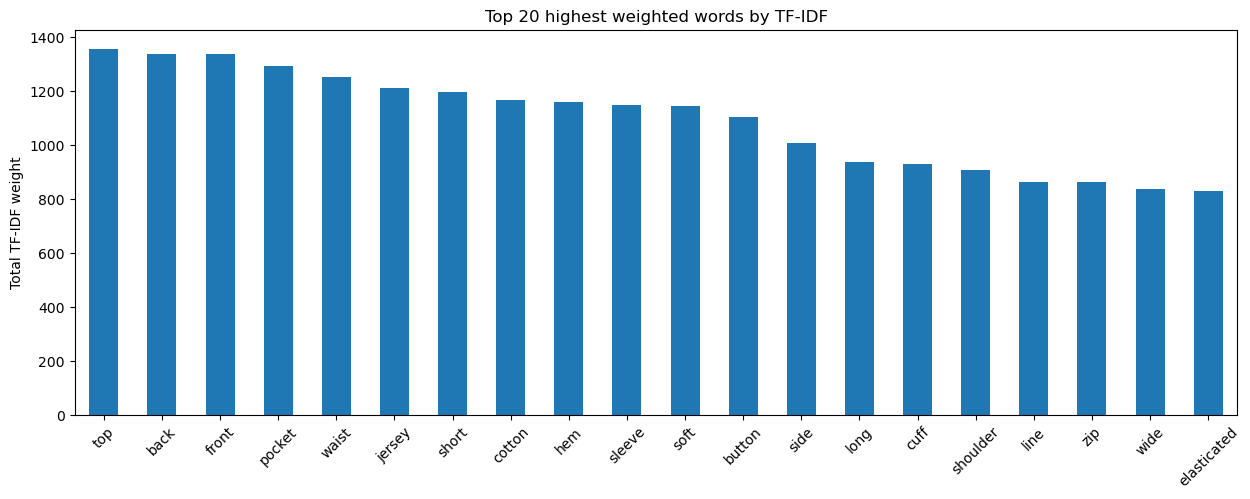

In [40]:
# Visualizing top 20 weighted words for detailed description
word_counts = pd.DataFrame(
    {"counts": X_train_desc_transformed.toarray().sum(axis=0)},
    index=tfidf_desc.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 highest weighted words by TF-IDF")
plt.ylabel('Total TF-IDF weight')
plt.xticks(rotation=45)
plt.show()

- Here we can see a more evenly distributed weight for detailed description
- we can see some words with body parts: "waist", "shoulder", "back"
- we can see some words with fabrics and touch: "cotton", "soft", "elasticated"

**Combine Vectorized Columns with Others**

In [41]:
# Getting dfs with pos neg prefixes
X_train_name_df = pd.DataFrame(columns='name_'+tfidf_name.get_feature_names_out(), 
                              data=X_train_name_transformed.toarray())
X_test_name_df = pd.DataFrame(columns='name_'+tfidf_name.get_feature_names_out(), 
                             data=X_test_name_transformed.toarray())
X_train_desc_df = pd.DataFrame(columns='desc_'+tfidf_desc.get_feature_names_out(), 
                              data=X_train_desc_transformed.toarray())
X_test_desc_df = pd.DataFrame(columns='desc_'+tfidf_desc.get_feature_names_out(), 
                             data=X_test_desc_transformed.toarray())

print(X_train_name_df.shape, X_test_name_df.shape, X_train_desc_df.shape, X_test_desc_df.shape)

(28962, 500) (7241, 500) (28962, 500) (7241, 500)


In [42]:
X_train_df = pd.concat([X_train_name_df, X_train_desc_df, X_train_og.reset_index(drop=True)], axis=1)
X_test_df = pd.concat([X_test_name_df, X_test_desc_df, X_test_og.reset_index(drop=True)], axis=1)

print(X_train_df.shape, X_test_df.shape)

(28962, 1129) (7241, 1129)


# Baseline Modeling & Evaluation

## Logistic Regression - without description and product name

**Baseline**

To begin with, let's look at the baseline for this prediction tasks by looking at how much accuracy we would get by guessing all of them as positive (since we have slightly more positive reviews):

In [43]:
y.value_counts(normalize=True)

trending
False    0.894152
True     0.105848
Name: proportion, dtype: float64

Our baseline accuracy is around 89.4%.

In [44]:
X_train = np.array(X_train_df)
X_test = np.array(X_test_df)
y_train = np.array(y_train)
y_test = np.array(y_test)

# og- without product description and product name
X_train_og = np.array(X_train_og)
X_test_og = np.array(X_test_og)

Next we can fit the data to the logistic regression model:

**Fitting the Model**

In [45]:
# Standard scaling the features
scaler = StandardScaler()
X_train_ss = scaler.fit_transform(X_train_og)
X_test_ss = scaler.transform(X_test_og)

# Fitting the model
logreg = LogisticRegression(random_state=123)
logreg.fit(X_train_ss, y_train)

# Training and test score
print(f"Train score: {logreg.score(X_train_ss, y_train)}")
print(f"Test score: {logreg.score(X_test_ss, y_test)}")

Train score: 0.8954492093087494
Test score: 0.8946278138378677


**Evaluating the Model**

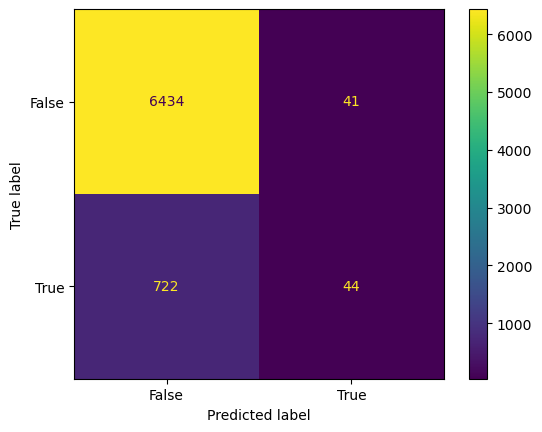

In [46]:
# Evaluate with confusion matrix
ConfusionMatrixDisplay.from_estimator(logreg, X_test_ss, y_test)
plt.show()

In [47]:
# evaluate on the original test set
y_pred = logreg.predict(X_test_ss)

# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.90      0.99      0.94      6475
        True       0.52      0.06      0.10       766

    accuracy                           0.89      7241
   macro avg       0.71      0.53      0.52      7241
weighted avg       0.86      0.89      0.86      7241



- In terms of precision, our model is correct 52% of the time when predicting trending items.
- Recall is quite low, the model only captures 0.06% of the trending items.

## Logistic Regression - with product name and detailed description

**Fitting the Model**

In [48]:
# Standard scaling the features
scaler = StandardScaler()
X_train_ss = scaler.fit_transform(X_train)
X_test_ss = scaler.transform(X_test)

# Fitting the model
logreg = LogisticRegression(random_state=123)
logreg.fit(X_train_ss, y_train)

# Training and test score
print(f"Train score: {logreg.score(X_train_ss, y_train)}")
print(f"Test score: {logreg.score(X_test_ss, y_test)}")

Train score: 0.9137490504799393
Test score: 0.8933848915895595


**Evaluating the Model**

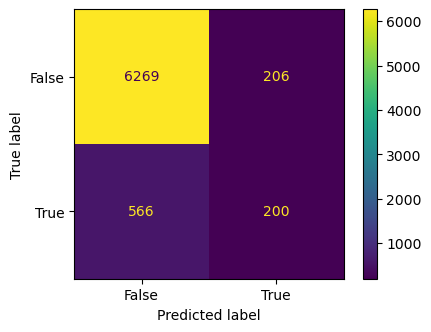

In [138]:
# Evaluate with confusion matrix
ConfusionMatrixDisplay.from_estimator(logreg, X_test_ss, y_test)
plt.show()

In [139]:
# evaluate on the original test set
y_pred = logreg.predict(X_test_ss)

# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.92      0.97      0.94      6475
        True       0.49      0.26      0.34       766

    accuracy                           0.89      7241
   macro avg       0.70      0.61      0.64      7241
weighted avg       0.87      0.89      0.88      7241



It looks like the logistic regression model (89.3%) is actually worse compared to the pure guessing baseline (89.4%). However,  the logreg is doing better by not classifying all items as non-trending.

Let's interpret these numbers, specifically the first row of the confusion matrix first:
* **TN**: The vast majority of data points are from class 0 that were correctly predicted as non-trending
* **FP**: 206 of non-trending items that we incorrectly classified as trending

Looking at the second column of the confusion matrix:

* **FN**: how many trending items were marked as non-trending?

- With product name and detailed description, recall is up by 20%!

## Imbalanced Learning

Since our data is imbalanced, it would be better if we had introduce some upsampling to our dataset.

### SMOTE

In [49]:
# Upsampling with SMOTE
from imblearn.over_sampling import SMOTE
sampler = SMOTE(random_state=123)
X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)
print(X_train_res.shape, y_train_res.shape)

(51792, 1129) (51792,)


**Fitting the Model**

In [50]:
# Standard scaling the features
scaler = StandardScaler()
X_train_ss = scaler.fit_transform(X_train_res)
X_test_ss = scaler.transform(X_test)

# Fitting the model
logreg = LogisticRegression(random_state=123)
logreg.fit(X_train_ss, y_train_res)

# Training and test score
print(f"Train score: {logreg.score(X_train_ss, y_train_res)}")
print(f"Test score: {logreg.score(X_test_ss, y_test)}")

Train score: 0.8692269076305221
Test score: 0.8091423836486673


**Evaluating the Model**

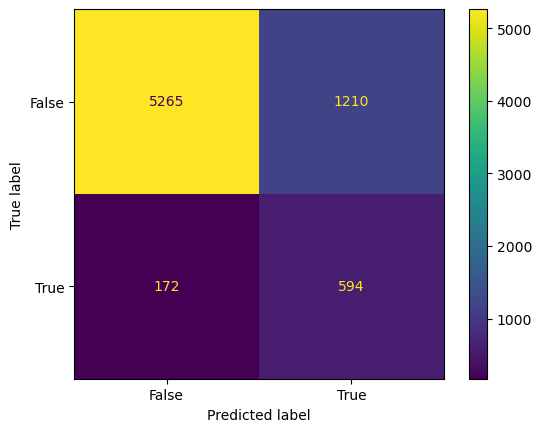

In [51]:
# Evaluate with confusion matrix
ConfusionMatrixDisplay.from_estimator(logreg, X_test_ss, y_test)
plt.show()

In [52]:
# evaluate on the original test set
y_pred = logreg.predict(X_test_ss)

# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.97      0.81      0.88      6475
        True       0.33      0.78      0.46       766

    accuracy                           0.81      7241
   macro avg       0.65      0.79      0.67      7241
weighted avg       0.90      0.81      0.84      7241



- Here we can see that we have a more satisfactory recall score, we can detect 78% of the trending items with this baseline model!

In [53]:
def false_positive_rate(y_true, y_pred):
    
    false_positives = (y_true == 0) & (y_pred == 1) # find all values where y is negative
                                                    # but we predicted positive
    false_positive_number = false_positives.sum()

    true_negatives = (y_true == 0) & (y_pred == 0)  # find all values where y is negative
                                                    # and we predicted negative
    true_negative_number = true_negatives.sum()

    # Finally, find the ratio of (FP) to (TN + FP)
    FPR = false_positive_number/(true_negative_number + false_positive_number)
    
    return FPR
fpr = false_positive_rate(y_test, y_pred)
fpr

0.18687258687258687

- False positive rate here could be improved, but compared to a 52% increase in recall this is still acceptable.

## Feature Importance

**Top 20 features**

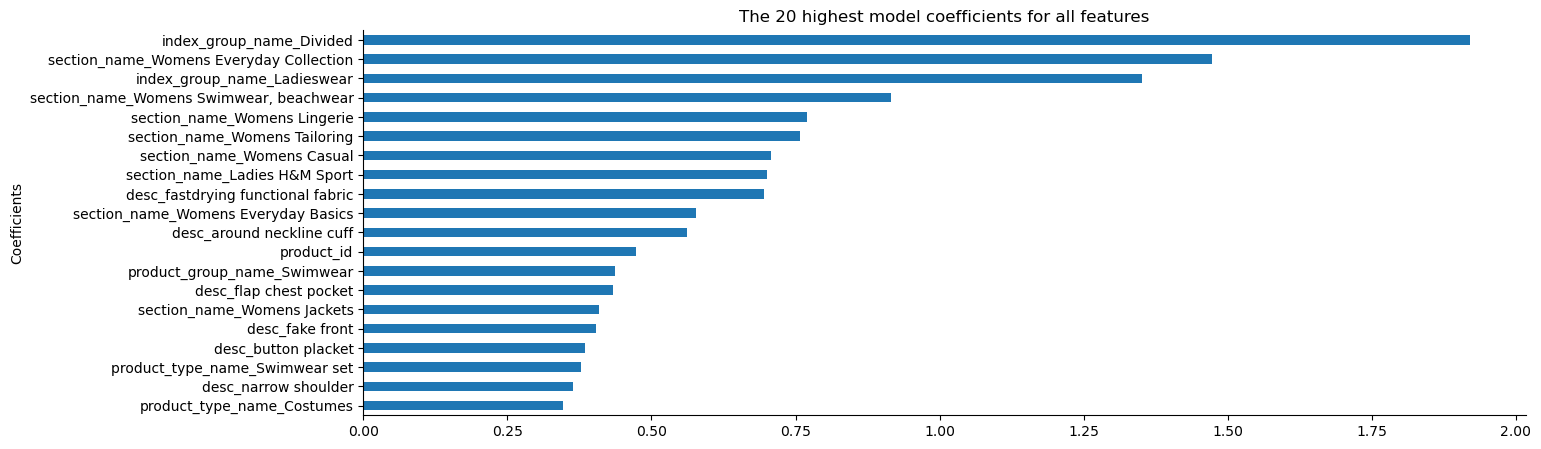

In [54]:
# Get our logreg model coefs for each features and pass them into a dataframe
word_coefs = pd.DataFrame(
    {"coefficients": logreg.coef_[0]},
    index = X_train_df.columns
).sort_values("coefficients", ascending=False)

# Plotting out the top 20 model coefs
word_coefs.head(20).plot(kind="barh", figsize=(15, 5), legend=False)
plt.title("The 20 highest model coefficients for all features")
plt.ylabel("Coefficients")
plt.gca().invert_yaxis()
sns.despine()
plt.show()

- We can see that sections are appearing very frequently in the top 20 coefficients in our model, this is indicating that this variable has a higher impact in helping the model make correct predictions. We might want to consider adding more similar features with higher variance into our model. (ex. department_name)
- Here we can already pin point some of the index_group, section, product_type, and product description that has the most trending potentials. We can suggest stakeholders to look further into these categories.

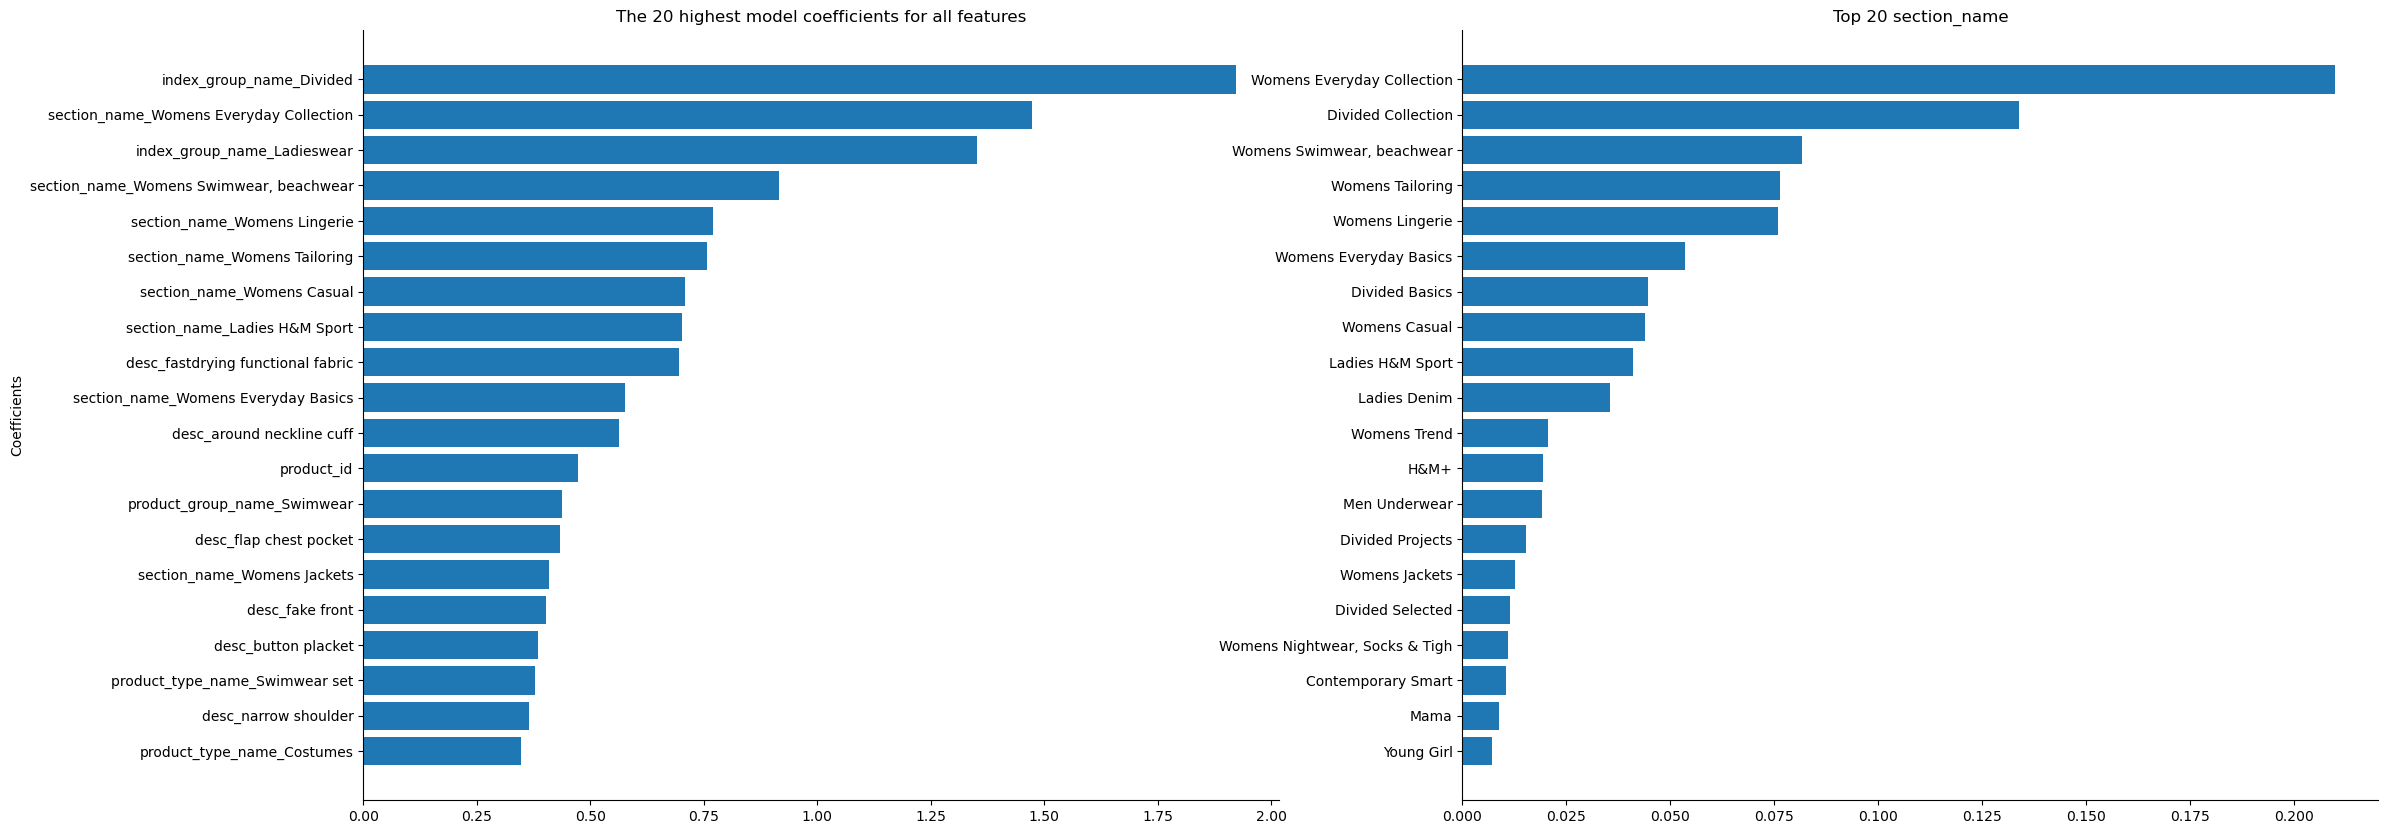

In [63]:
plt.subplots(1,2, figsize=(26,10))

plt.subplot(1,2,1)
# Plotting out the top 20 model coefs
top_values = word_coefs.reset_index().head(20)
plt.barh(top_values.iloc[:,0], top_values.iloc[:,1])
plt.title("The 20 highest model coefficients for all features")
plt.ylabel("Coefficients")
plt.gca().invert_yaxis()
sns.despine()

plt.subplot(1,2,2)
col = 'section_name'
sec_values = hm_sales_processed[col].value_counts(normalize=True).head(20)
plt.barh(sec_values.index, sec_values.values)
plt.gca().invert_yaxis()
plt.title(f'Top 20 {col}')
sns.despine()

With these features with high coefficients, we can actually match with it from the top 20 selling section name, and pin point specific sections that have more trending natures.

###### **Top 20 detailed description**

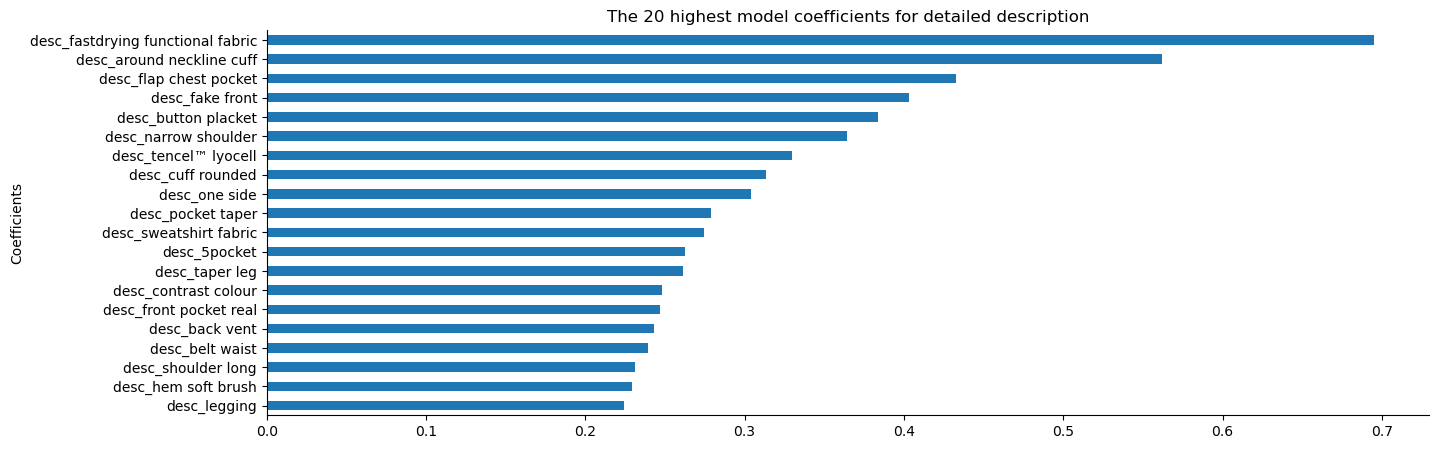

In [64]:
# Filter only the index (columns) with "desc_" prefix
word_coefs_desc = word_coefs.T.filter(like='desc_').T

# Plotting out the top 20 model coefs
word_coefs_desc.head(20).plot(kind="barh", figsize=(15, 5), legend=False)
plt.title("The 20 highest model coefficients for detailed description")
plt.ylabel("Coefficients")
plt.gca().invert_yaxis()
sns.despine()
plt.show()

Here, we can also look at only the detailed product description:
- We can see body parts commonly occurs in the top 20 coefs, such as neckline, shoulder, leg, waist.
- Fabrics and pockets also seems to occur quite often.


**Next Steps**

- Compare more ML / NN models and optimize the precision / recall /f1 score, also look at AUC/ROC.
- Bring in more columns with variance and feature engineering them to see if we can improve model performance.
- Perform a Kmeans clustering on different categories and within categories to see if we can further retrieve some patterns.
- Create a plotly dashboard to visualize trends.

In [ ]:
ddd

# Advanced ML Modelling

Using the baseline models and model evaluation strategy you built in the previous part, we will springboard into advanced model building, optimization, evaluation and interpretation. Here are the steps:
- Create a pipeline for tokenization, scaling, and imbalanced learning
- Implement the pipeline for hyperparameter optimization with baseline model
- Apply the methods to other ML models

In [8]:
# Read the if start from here
prod_df = pd.read_csv('data/prod_df.csv')

## Pipeline

For efficiency purposes and reusability, here we want to wrap up all our feature engineering steps and modelling with column transformer and pipelines.

**First, we need to retrieve our tokenizer**

In [10]:
# Custom tokenizer using lemmatizing
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


lemmatizer = WordNetLemmatizer()

ENGLISH_STOP_WORDS = stopwords.words('english')
# Include words we want to clean in stop words
ENGLISH_STOP_WORDS.extend(['none','no', 'nothing','n','a','negative','positive'])

def my_lemma_tokenizer(sentence):
    # # remove punctuation, numbers, and set to lower case
    # sentence = re.sub(r'[^a-zA-Z\s]', '', sentence).lower()
    
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    pos_tags = nltk.pos_tag(listofwords)
    listoflemmatized_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word, tag in pos_tags:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Lemmatized words
            
            lemmatized_word = lemmatizer.lemmatize(word,get_wordnet_pos(tag))
            listoflemmatized_words.append(lemmatized_word)

    return listoflemmatized_words

**Next, we can use pipeline to wrap all the steps together**  
- TfidfVectorizer
- StandardScaler
- OneHotEncoder
- SMOTE Upsamping
- ML model

**Train Test Split**

In [87]:
# Spliting features X and target y 
X = prod_df.drop(['trending', 'product_id'], axis=1)
y = prod_df['trending']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)
print(X_train.shape, X_test.shape)

(28962, 8) (7241, 8)


**Defining Pipeline Function**

In [124]:
def hm_pipeline(model):
    """
    Create an imbalanced-learn pipeline for text and categorical feature processing,
    applying Synthetic Minority Over-sampling Technique (SMOTE), and a specified model.

    Parameters:
    - model: The classification model to be used in the pipeline.

    Returns:
    - ImbPipeline: An imbalanced-learn pipeline that includes text and categorical feature processing,
      SMOTE for dealing with class imbalance, and the specified classification model.
    
    Example:
    >>> from sklearn.ensemble import RandomForestClassifier
    >>> from imblearn.pipeline import Pipeline as ImbPipeline
    >>> model = RandomForestClassifier()
    >>> pipeline = hm_pipeline(model)
    >>> pipeline.fit(X_train, y_train)
    >>> y_pred = pipeline.predict(X_test)
    """
    # Columns for one-hot encoding
    categorical_columns = ['product_type_name', 'product_group_name', 'index_group_name', 'section_name', 'graphical_appearance_name']
    
    # Create the column transformations list + columns to which to apply
    col_transforms = [('desc', TfidfVectorizer(max_features=500, min_df=10, tokenizer=my_lemma_tokenizer, ngram_range=(1, 3)), 'detail_desc'),
                      ('name', TfidfVectorizer(max_features=500, min_df=10, tokenizer=my_lemma_tokenizer, ngram_range=(1, 3)), 'prod_name'),
                      ('normalise', StandardScaler(), ['unit_price']),
                      ('cat', OneHotEncoder(drop='first'), categorical_columns)
                     ]
    
    # Create the column transformer
    col_trans = ColumnTransformer(col_transforms)
    
    # List of estimators in the pipeline
    estimators = [('preprocessor', col_trans),
                  ('to_dense', FunctionTransformer(func=to_dense, validate=False)),
                  ('smote', SMOTE(random_state=123)),
                  ('clf', model)
                 ]
    
    # Create and return the imbalanced-learn pipeline
    return ImbPipeline(estimators)

**Testing out the pipeline with Logistic Regression Model**

In [37]:
# Specify the model for the pipeline
model_params = {'random_state':123}
model = LogisticRegression(**model_params)

# Instantiate pipeline with our custom function
pipe = hm_pipeline(model)

# Fitting the pipeline with training data
pipe.fit(X_train, y_train)

# Predicting with test data
y_pred = pipe.predict(X_test)

# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.97      0.80      0.88      6475
        True       0.32      0.80      0.46       766

    accuracy                           0.80      7241
   macro avg       0.65      0.80      0.67      7241
weighted avg       0.90      0.80      0.83      7241



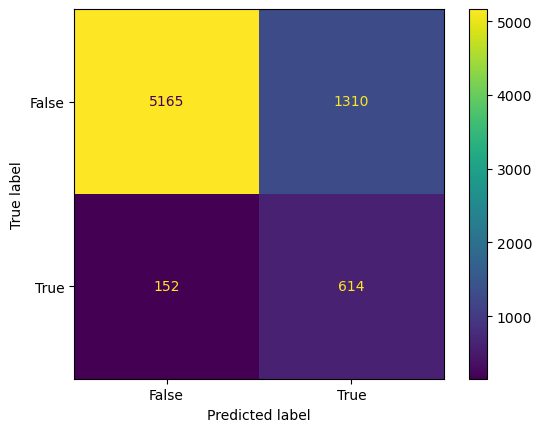

In [27]:
# Evaluate with confusion matrix
ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test)
plt.show()

Here we can see that we have a slightly higher recall score (**80%**). That might be due to the order difference of our steps (putting standard scaler before one-hot encoder).

**For model comparison, we also want to create a function that calculates our desired evaluation metrics**

In [43]:
def calculate_metrics(model_name, model_params, y_true, y_pred):
    """
    Calculate precision, recall, F1 score, accuracy, and false positive rate.

    Parameters:
    - y_true: true labels
    - y_pred: predicted labels
    - model_name: name of the classification model
    - model_params: dictionary containing the model parameters

    Returns:
    - metrics_dict: a dictionary containing precision, recall, f1_score, accuracy, false_positive_rate,
      model_name, and model_params
    """
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate true positives, false positives, false negatives, true negatives
    tp = cm[1, 1]
    fp = cm[0, 1]
    fn = cm[1, 0]
    tn = cm[0, 0]

    # Calculate precision, recall, F1 score, accuracy, and false positive rate
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    false_positive_rate = fp / (fp + tn) if (fp + tn) != 0 else 0.0

    # Create a dictionary to store the metrics and model specifications
    metrics_dict = {
        'model_name': model_name,
        'model_params': model_params,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'accuracy': accuracy,
        'false_positive_rate': false_positive_rate
    }

    return metrics_dict

**Model Evaluation**

In [45]:
# Extract model specifications
model_name = 'LogisticRegression'
model_params = pipe.named_steps['clf'].get_params()

# Calculate metrics and include model specifications
metrics_dict = calculate_metrics(model_name, model_params, y_test, y_pred)

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame([metrics_dict])

# Reorder columns to have model_name and model_params at the front
columns_order = ['model_name', 'model_params', 'precision', 'recall', 'f1_score', 'accuracy', 'false_positive_rate']
metrics_df = metrics_df[columns_order]

# Display the resulting DataFrame
metrics_df

model_name                                       model_params  \
0  LogisticRegression  {'C': 1.0, 'class_weight': None, 'dual': False...   

   precision    recall  f1_score  accuracy  false_positive_rate  
0   0.319127  0.801567  0.456506  0.798094             0.202317

**Let's use the pipeline and evaluation metrics function for hyperparmater optimization with our baseline model**

In [58]:
def print_progress_bar(iteration, total, prefix='', suffix='', length=30, fill='█', print_end='\r'):
    """
    Print a text-based progress bar.

    Parameters:
    - iteration: Current iteration (int)
    - total: Total iterations (int)
    - prefix: Prefix string (str)
    - suffix: Suffix string (str)
    - length: Length of the progress bar (int)
    - fill: Fill character for the progress bar (str)
    - print_end: String appended after the progress bar (e.g., '\r' for carriage return)
    """
    percent = ("{0:.1f}").format(100 * (iteration / float(total)))
    filled_length = int(length * iteration // total)
    bar = fill * filled_length + '-' * (length - filled_length)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end=print_end, flush=True)

**Looping through different Cs and store results**

In [61]:
# Empty dataframe to store results
all_metrics_df = pd.DataFrame()

# For loop through different C's for logistic regression
Cs = [0.001, 0.01, 0.1, 1, 10, 100]
for i, c in enumerate(Cs):
    # Progress
    print_progress_bar(i+1, len(Cs), prefix='Progress:', suffix='Complete', length=30)
    
    # Specify the model for the pipeline
    model_name = 'LogisticRegression'
    model_params = {'C':c, 'random_state':123}
    model = LogisticRegression(**model_params)
    
    # Instantiate pipeline with our custom function
    pipe = hm_pipeline(model)
    
    # Fitting the pipeline with training data
    pipe.fit(X_train, y_train)
    
    # Predicting with test data
    y_pred = pipe.predict(X_test)
    
    # Calculate metrics and include model specifications
    metrics_dict = calculate_metrics(model_name, model_params, y_test, y_pred)
    
    # Convert the dictionary to a DataFrame
    metrics_df = pd.DataFrame([metrics_dict])
    
    # Reorder columns to have model_name and model_params at the front
    columns_order = ['model_name', 'model_params', 'precision', 'recall', 'f1_score', 'accuracy', 'false_positive_rate']
    metrics_df = metrics_df[columns_order]

    # Append the metrics_df to the all_metrics_df
    all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

# Display the resulting DataFrame
all_metrics_df

model_name                       model_params  precision    recall  \
0  LogisticRegression  {'C': 0.001, 'random_state': 123}   0.257201  0.827676   
1  LogisticRegression   {'C': 0.01, 'random_state': 123}   0.271296  0.877285   
2  LogisticRegression    {'C': 0.1, 'random_state': 123}   0.299535  0.840731   
3  LogisticRegression      {'C': 1, 'random_state': 123}   0.319127  0.801567   
4  LogisticRegression     {'C': 10, 'random_state': 123}   0.321101  0.776762   
5  LogisticRegression    {'C': 100, 'random_state': 123}   0.320623  0.779373   

   f1_score  accuracy  false_positive_rate  
0  0.392448  0.728905             0.282780  
1  0.414431  0.737743             0.278764  
2  0.441701  0.775169             0.232587  
3  0.456506  0.798094             0.202317  
4  0.454372  0.802652             0.194286  
5  0.454338  0.801961             0.195367

In [62]:
# saving logreg results
# all_metrics_df.to_csv('data/logreg_results.csv', index=False)

Since the goal for this project is to predict trending items, and the data is imbalanced, what we want to optimize is the recall score instead of accuracy. Hence, we might consider the best logistic regression model to be the one with C=0.01, which can identify 87.7% of trending items.

**Next, we can start applying our pipeline on other models**

## SVM

We start with the kernel SVM model here, and loop through different Cs (Regularization Parameter). A smaller C encourages a larger margin and a simpler decision boundary, but may misclassify some points. A larger C gives a lower margin but classifies all training points correctly.

In [66]:
# For loop through different C's for logistic regression
Cs = [0.001, 0.01, 0.1, 1, 10, 100]
for i, c in enumerate(Cs):
    # Specify the model for the pipeline
    model_name = 'SVM'
    model_params = {'C':c, 'kernel':'rbf', 'random_state':123}
    model = SVC(**model_params)
    
    # Instantiate pipeline with our custom function
    pipe = hm_pipeline(model)
    
    # Fitting the pipeline with training data
    pipe.fit(X_train, y_train)
    
    # Predicting with test data
    y_pred = pipe.predict(X_test)
    
    # Calculate metrics and include model specifications
    metrics_dict = calculate_metrics(model_name, model_params, y_test, y_pred)
    
    # Convert the dictionary to a DataFrame
    metrics_df = pd.DataFrame([metrics_dict])
    
    # Reorder columns to have model_name and model_params at the front
    columns_order = ['model_name', 'model_params', 'precision', 'recall', 'f1_score', 'accuracy', 'false_positive_rate']
    metrics_df = metrics_df[columns_order]

    # Append the metrics_df to the all_metrics_df
    all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

    # Progress
    print_progress_bar(i+1, len(Cs), prefix='Progress:', suffix='Complete', length=30)
    
# Display the resulting DataFrame
all_metrics_df

model_name                                       model_params  \
0   LogisticRegression                  {'C': 0.001, 'random_state': 123}   
1   LogisticRegression                   {'C': 0.01, 'random_state': 123}   
2   LogisticRegression                    {'C': 0.1, 'random_state': 123}   
3   LogisticRegression                      {'C': 1, 'random_state': 123}   
4   LogisticRegression                     {'C': 10, 'random_state': 123}   
5   LogisticRegression                    {'C': 100, 'random_state': 123}   
6                  SVM  {'C': 0.001, 'kernel': 'rbf', 'random_state': ...   
7                  SVM  {'C': 0.01, 'kernel': 'rbf', 'random_state': 123}   
8                  SVM   {'C': 0.1, 'kernel': 'rbf', 'random_state': 123}   
9                  SVM     {'C': 1, 'kernel': 'rbf', 'random_state': 123}   
10                 SVM    {'C': 10, 'kernel': 'rbf', 'random_state': 123}   
11                 SVM   {'C': 100, 'kernel': 'rbf', 'random_state': 123}   

    precision    recall  f1_score  accuracy  false_positive_rate  
0    0.257201  0.827676  0.392448  0.728905             0.282780  
1    0.271296  0.877285  0.414431  0.737743             0.278764  
2    0.299535  0.840731  0.441701  0.775169             0.232587  
3    0.319127  0.801567  0.456506  0.798094             0.202317  
4    0.321101  0.776762  0.454372  0.802652             0.194286  
5    0.320623  0.779373  0.454338  0.801961             0.195367  
6    0.253412  0.557441  0.348429  0.779450             0.194286  
7    0.262642  0.874674  0.403979  0.726971             0.290502  
8    0.305825  0.822454  0.445860  0.783732             0.220849  
9    0.407149  0.609661  0.488238  0.864798             0.105019  
10   0.454315  0.467363  0.460746  0.884270             0.066409  
11   0.444921  0.406005  0.424573  0.883580             0.059923

In [67]:
# saving logreg results
# all_metrics_df.to_csv('data/svm_results.csv', index=False)

## XGBoost

In [120]:
# Specify the model for the pipeline
model_name = 'XGBoost'
model_params = {'objective':'binary:logistic', 
                'random_state':123}
model = XGBClassifier(**model_params)

# Instantiate pipeline with our custom function
pipe = hm_pipeline(model)

# Define the hyperparameter grid to search
param_grid = {
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5],
    'clf__n_estimators': [50, 100, 200, 300, 500]
}

# Use GridSearchCV to find the best combination of hyperparameters
grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring='recall', verbose=2)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print classification report
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Calculate metrics and include model specifications
metrics_dict = calculate_metrics(model_name, best_params, y_test, y_pred)

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame([metrics_dict])

# Reorder columns to have model_name and model_params at the front
columns_order = ['model_name', 'model_params', 'precision', 'recall', 'f1_score', 'accuracy', 'false_positive_rate']
metrics_df = metrics_df[columns_order]
metrics_df

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END classifier__learning_rate=0.01, classifier__n_estimators=50; total time=  26.8s
[CV] END classifier__learning_rate=0.01, classifier__n_estimators=50; total time=  27.3s
[CV] END classifier__learning_rate=0.01, classifier__n_estimators=50; total time=  28.3s
[CV] END classifier__learning_rate=0.01, classifier__n_estimators=100; total time=  29.8s
[CV] END classifier__learning_rate=0.01, classifier__n_estimators=100; total time=  28.9s
[CV] END classifier__learning_rate=0.01, classifier__n_estimators=100; total time=  31.9s
[CV] END classifier__learning_rate=0.01, classifier__n_estimators=200; total time=  35.2s
[CV] END classifier__learning_rate=0.01, classifier__n_estimators=200; total time=  34.4s
[CV] END classifier__learning_rate=0.01, classifier__n_estimators=200; total time=  33.7s
[CV] END classifier__learning_rate=0.01, classifier__n_estimators=300; total time=  38.9s
[CV] END classifier__learning_rate=0.01, c

model_name                                       model_params  precision  \
0    XGBoost  {'classifier__learning_rate': 0.01, 'classifie...   0.255233   

     recall  f1_score  accuracy  false_positive_rate  
0  0.827676  0.390154  0.726281             0.285714

## Random Forest

**Random Forest Baseline**

In [122]:
# Specify the model for the pipeline
model_name = 'RandomForest'
model_params = {'random_state':123}
model = RandomForestClassifier(**model_params)

# Instantiate pipeline with our custom function
pipe = hm_pipeline(model)
pipe.fit(X_train, y_train)

# Predicting with test data
y_pred = pipe.predict(X_test)

# Calculate metrics and include model specifications
metrics_dict = calculate_metrics(model_name, model_params, y_test, y_pred)

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame([metrics_dict])

# Reorder columns to have model_name and model_params at the front
columns_order = ['model_name', 'model_params', 'precision', 'recall', 'f1_score', 'accuracy', 'false_positive_rate']
metrics_df = metrics_df[columns_order]
metrics_df

model_name           model_params  precision    recall  f1_score  \
0  RandomForest  {'random_state': 123}   0.459954  0.262402  0.334165   

   accuracy  false_positive_rate  
0   0.88938             0.036448

**Grid Search**

In [125]:
# Specify the model for the pipeline
model_name = 'RandomForest'
model_params = {'random_state':123}
model = RandomForestClassifier(**model_params)

# Instantiate pipeline with our custom function
pipe = hm_pipeline(model)

# Define the hyperparameter grid to search
param_grid = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

# Use GridSearchCV to find the best combination of hyperparameters
grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring='recall', verbose=2)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print classification report
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Calculate metrics and include model specifications
metrics_dict = calculate_metrics(model_name, best_params, y_test, y_pred)

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame([metrics_dict])

# Reorder columns to have model_name and model_params at the front
columns_order = ['model_name', 'model_params', 'precision', 'recall', 'f1_score', 'accuracy', 'false_positive_rate']
metrics_df = metrics_df[columns_order]
metrics_df

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=50; total time=  30.9s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=50; total time=  30.7s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=50; total time=  31.4s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=  37.6s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=  38.6s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=  37.4s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=200; total time=  49.6s
[CV] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2,

KeyboardInterrupt: 

In [139]:
# Print the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print classification report
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Calculate metrics and include model specifications
metrics_dict = calculate_metrics(model_name, best_params, y_test, y_pred)

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame([metrics_dict])

# Reorder columns to have model_name and model_params at the front
columns_order = ['model_name', 'model_params', 'precision', 'recall', 'f1_score', 'accuracy', 'false_positive_rate']
metrics_df = metrics_df[columns_order]
metrics_df